This is needed to reload modules without restarting the kernel

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# Line above avoids running on GPU

This is needed to add eda_tools from the directories above

In [3]:
import os
os.sys.path.append('../../')


Base Packages

In [4]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

Base plotting style

In [5]:
import mplhep as hep
hep.set_style('ATLAS')

In [6]:
errorbar_style = {
    'linestyle': 'none',
    'marker': '.',
    'elinewidth': 1,
    'capsize': 1,
    'color': 'k',
}


# Setup

In [7]:
file_path_data_fmp_18  = '/mnt/storage/lborgna/NNT/MDR_VEC/data/data_2B_SRshift_fmp_16.root'

In [8]:
from hh4b_utils.nnt_tools import load_nnt

In [9]:
data_fmp = load_nnt(
    file_path_data_fmp_18,
    trees=["fullmassplane"],
)

100%|██████████| 219/219 [03:20<00:00,  1.09it/s]


In [10]:
def ellipse(mh1, mh2, a, b):
    
    MH1 = ((mh1-124)**2)/(a**2)
    MH2 = ((mh2-117)**2)/(b**2)
    
    r = np.sqrt(MH1+MH2)
    
    return r

In [11]:
from hh4b_utils.nnt_tools import xhh, crhh, vrhh

# Reweighting New and old CRs

In [12]:
data_fmp = data_fmp[~data_fmp.pass_vbf_sel].reset_index(drop=True)

In [13]:
data_fmp.head()

run_number  event_number  pass_vbf_sel  mc_sf  trig_sf  jet_trig_sfs  \
0      298773        988881         False    1.0      1.0           1.0   
1      298773        801327         False    1.0      1.0           1.0   
2      298773       1150174         False    1.0      1.0           1.0   
3      298773       1000770         False    1.0      1.0           1.0   
4      298773       1693750         False    1.0      1.0           1.0   

   truth_mhh  ntag  njets  kinematic_region  ...  tagged_vbf_j1  m_vbf_j2  \
0        0.0     2      4                 3  ...          False       0.0   
1        0.0     2      4                 3  ...          False       0.0   
2        0.0     2      4                 0  ...          False       0.0   
3        0.0     2      4                 3  ...          False       0.0   
4        0.0     2      4                 1  ...          False       0.0   

   E_vbf_j2  pT_vbf_j2  eta_vbf_j2  phi_vbf_j2  tagged_vbf_j2  vbf_mjj  \
0       0.0        0.0         0.0         0.0          False      0.0   
1       0.0        0.0         0.0         0.0          False      0.0   
2       0.0        0.0         0.0         0.0          False      0.0   
3       0.0        0.0         0.0         0.0          False      0.0   
4       0.0        0.0         0.0         0.0          False      0.0   

   vbf_dEtajj  vbf_pTvecsum  
0         0.0           0.0  
1         0.0           0.0  
2         0.0           0.0  
3         0.0           0.0  
4         0.0           0.0  

[5 rows x 89 columns]

In [14]:
data_fmp['kr_original'] = data_fmp['kinematic_region']

In [15]:
from eda_tools.utilities import calculatedPhi, calculatedRhh

/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


In [16]:
calculatedRhh(data_fmp)
calculatedPhi(data_fmp)

In [17]:
mask_SR = (ellipse(data_fmp['m_h1'],data_fmp['m_h2'],1,1.15) <=24)

In [18]:
mask_SR.value_counts()

False    17782586
True       706775
dtype: int64

In [19]:
mask_CRnew = (ellipse(data_fmp['m_h1'],data_fmp['m_h2'], 1, 1.15)> 24) & (ellipse(data_fmp['m_h1'],data_fmp['m_h2'], 1, 1.15) <= 40)

In [20]:
mask_CRnew.value_counts()

False    17308138
True      1181223
dtype: int64

In [21]:
data_fmp.loc[mask_SR, 'kr_new'] = 0 
data_fmp.loc[mask_CRnew,'kr_new'] = 2

In [22]:
mask_CRold = (~mask_SR) & (crhh(data_fmp['m_h1'],data_fmp['m_h2'], 124, 117) < 45)

In [23]:
data_fmp.loc[mask_SR, 'kr_old'] = 0
data_fmp.loc[mask_CRold, 'kr_old'] =2

In [24]:

from eda_tools import NN_RW as nn

Using TensorFlow backend.


In [25]:
nominal = nn.nominal()

In [26]:
rw_cols_to_log = nominal['rw_cols_to_log']
rw_cols_log = nominal['rw_cols_log']

In [27]:
rw_cols_to_log[-1] = 'X_wt_tag'
rw_cols_log[-4] = 'X_wt_tag_log'

In [28]:
nn.log_inputs(data_fmp, to_log=rw_cols_to_log)

In [29]:
data_fmp['kinematic_region'] = data_fmp['kr_new']

In [30]:
data_fmp.shape

(18489361, 101)

In [31]:
from hh4b_utils.plot_tools import hist2d

In [32]:
x, y = np.linspace(20, 200, 1000), np.linspace(20, 200, 1000)

In [33]:
X, Y = np.meshgrid(x,y)

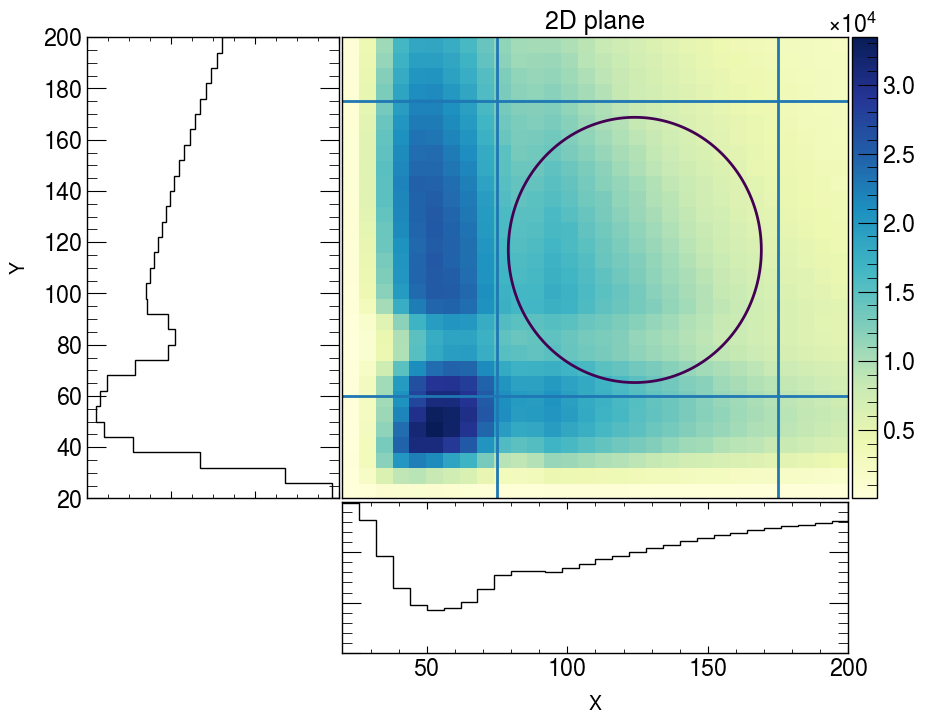

In [34]:
h = hist2d(data_fmp.m_h1, data_fmp.m_h2)
h['main_ax'].contour(X, Y, ellipse(X, Y, 1, 1.15), [45])
h['main_ax'].axvline(75)
h['main_ax'].axvline(175)
h['main_ax'].axhline(60)
h['main_ax'].axhline(175)

In [35]:
mask = (data_fmp.m_h1 > 75) & (data_fmp.m_h1 < 175) & (data_fmp.m_h2 > 60) & (data_fmp.m_h2 < 175)

In [36]:
d_r = data_fmp.loc[mask].reset_index(drop=True)

In [37]:
d_r.shape

(3633383, 101)

In [38]:
d_old = d_r.copy()

In [39]:
d_r['kinematic_region'] = d_r['kr_original']

### Original Kinematic Regions Training

In [40]:
df_w_og, mu_bs_og = nn.repeatNNtrain(
    d_r,
    repeat=20,
    kinematic_region=2,
    sort_rw_cols=rw_cols_log,
    epochs=500,
    save=True,
    batch_size=10000,
    model_storage_directory="/mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/",
)

  0%|          | 0/20 [00:00<?, ?it/s]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 598405 samples, validate on 398938 samples
Epoch 1/500
598405/598405 [==============================] - 2s 4us/step - loss: 0.9170 - accuracy: 0.0730 - val_loss: 0.7755 - val_accuracy: 0.0040

Epoch 00001: val_loss improved from inf to 0.77551, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n0.h5
Epoch 2/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.6428 - accuracy: 0.0021 - val_loss: 0.5277 - val_accuracy: 7.2693e-05

Epoch 00002: val_loss improved from 0.77551 to 0.52772, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n0.h5
Epoch 3/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.4021 - accuracy: 3.3088e-04 - val_loss: 0.3185 - val_accuracy: 1.5040e-05

Epoch 00003: val_loss improved from 0

  5%|▌         | 1/20 [00:30<09:40, 30.57s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 598405 samples, validate on 398938 samples
Epoch 1/500
598405/598405 [==============================] - 2s 3us/step - loss: 0.9104 - accuracy: 0.0704 - val_loss: 0.7854 - val_accuracy: 0.0049

Epoch 00001: val_loss improved from inf to 0.78541, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n1.h5
Epoch 2/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.6369 - accuracy: 0.0021 - val_loss: 0.5158 - val_accuracy: 1.0528e-04

Epoch 00002: val_loss improved from 0.78541 to 0.51580, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n1.h5
Epoch 3/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.4089 - accuracy: 2.3228e-04 - val_loss: 0.3192 - val_accuracy: 4.0106e-05

Epoch 00003: val_loss improved from 0

 10%|█         | 2/20 [00:59<08:59, 29.96s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 598405 samples, validate on 398938 samples
Epoch 1/500
598405/598405 [==============================] - 2s 3us/step - loss: 0.9312 - accuracy: 0.0826 - val_loss: 0.7772 - val_accuracy: 0.0034

Epoch 00001: val_loss improved from inf to 0.77722, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n2.h5
Epoch 2/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.6446 - accuracy: 0.0022 - val_loss: 0.5360 - val_accuracy: 2.0053e-05

Epoch 00002: val_loss improved from 0.77722 to 0.53603, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n2.h5
Epoch 3/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.4158 - accuracy: 2.3563e-04 - val_loss: 0.3366 - val_accuracy: 1.0027e-05

Epoch 00003: val_loss improved from 0

 15%|█▌        | 3/20 [01:27<08:21, 29.48s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 598405 samples, validate on 398938 samples
Epoch 1/500
598405/598405 [==============================] - 2s 3us/step - loss: 0.9141 - accuracy: 0.0846 - val_loss: 0.7909 - val_accuracy: 0.0051

Epoch 00001: val_loss improved from inf to 0.79086, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n3.h5
Epoch 2/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.6238 - accuracy: 0.0022 - val_loss: 0.5280 - val_accuracy: 7.2693e-05

Epoch 00002: val_loss improved from 0.79086 to 0.52797, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n3.h5
Epoch 3/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.3907 - accuracy: 3.4091e-04 - val_loss: 0.3219 - val_accuracy: 1.5040e-05

Epoch 00003: val_loss improved from 0

 20%|██        | 4/20 [01:51<07:27, 27.97s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 598405 samples, validate on 398938 samples
Epoch 1/500
598405/598405 [==============================] - 2s 3us/step - loss: 0.9152 - accuracy: 0.0763 - val_loss: 0.7777 - val_accuracy: 0.0043

Epoch 00001: val_loss improved from inf to 0.77769, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n4.h5
Epoch 2/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.6295 - accuracy: 0.0019 - val_loss: 0.5117 - val_accuracy: 1.3536e-04

Epoch 00002: val_loss improved from 0.77769 to 0.51168, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n4.h5
Epoch 3/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.3959 - accuracy: 2.1390e-04 - val_loss: 0.3128 - val_accuracy: 2.7573e-05

Epoch 00003: val_loss improved from 0

 25%|██▌       | 5/20 [02:15<06:39, 26.66s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 598405 samples, validate on 398938 samples
Epoch 1/500
598405/598405 [==============================] - 2s 3us/step - loss: 0.9260 - accuracy: 0.0804 - val_loss: 0.7684 - val_accuracy: 0.0041

Epoch 00001: val_loss improved from inf to 0.76836, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n5.h5
Epoch 2/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.6442 - accuracy: 0.0024 - val_loss: 0.5086 - val_accuracy: 1.8549e-04

Epoch 00002: val_loss improved from 0.76836 to 0.50861, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n5.h5
Epoch 3/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.4083 - accuracy: 3.7600e-04 - val_loss: 0.3125 - val_accuracy: 7.0186e-05

Epoch 00003: val_loss improved from 0

 30%|███       | 6/20 [02:40<06:04, 26.03s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 598405 samples, validate on 398938 samples
Epoch 1/500
598405/598405 [==============================] - 2s 3us/step - loss: 0.9115 - accuracy: 0.0748 - val_loss: 0.7513 - val_accuracy: 0.0021

Epoch 00001: val_loss improved from inf to 0.75133, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n6.h5
Epoch 2/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.6245 - accuracy: 0.0016 - val_loss: 0.4845 - val_accuracy: 3.2587e-05

Epoch 00002: val_loss improved from 0.75133 to 0.48454, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n6.h5
Epoch 3/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.3864 - accuracy: 1.8382e-04 - val_loss: 0.2999 - val_accuracy: 3.0080e-05

Epoch 00003: val_loss improved from 0

 35%|███▌      | 7/20 [03:05<05:36, 25.88s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 598405 samples, validate on 398938 samples
Epoch 1/500
598405/598405 [==============================] - 2s 3us/step - loss: 0.9036 - accuracy: 0.0725 - val_loss: 0.7108 - val_accuracy: 8.8736e-04

Epoch 00001: val_loss improved from inf to 0.71082, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n7.h5
Epoch 2/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.6168 - accuracy: 0.0023 - val_loss: 0.4533 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 0.71082 to 0.45332, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n7.h5
Epoch 3/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.3946 - accuracy: 2.9746e-04 - val_loss: 0.2924 - val_accuracy: 5.0133e-06

Epoch 00003: val_loss improved fr

 40%|████      | 8/20 [03:33<05:16, 26.38s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 598405 samples, validate on 398938 samples
Epoch 1/500
598405/598405 [==============================] - 2s 3us/step - loss: 0.9139 - accuracy: 0.0706 - val_loss: 0.7234 - val_accuracy: 9.5002e-04

Epoch 00001: val_loss improved from inf to 0.72339, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n8.h5
Epoch 2/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.6262 - accuracy: 0.0020 - val_loss: 0.4658 - val_accuracy: 2.5067e-05

Epoch 00002: val_loss improved from 0.72339 to 0.46583, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n8.h5
Epoch 3/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.3890 - accuracy: 2.9244e-04 - val_loss: 0.2960 - val_accuracy: 1.7547e-05

Epoch 00003: val_loss improved fr

 45%|████▌     | 9/20 [03:58<04:47, 26.17s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 598405 samples, validate on 398938 samples
Epoch 1/500
598405/598405 [==============================] - 2s 3us/step - loss: 0.9190 - accuracy: 0.0807 - val_loss: 0.7581 - val_accuracy: 0.0034

Epoch 00001: val_loss improved from inf to 0.75812, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n9.h5
Epoch 2/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.6245 - accuracy: 0.0023 - val_loss: 0.5034 - val_accuracy: 1.0528e-04

Epoch 00002: val_loss improved from 0.75812 to 0.50340, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n9.h5
Epoch 3/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.3986 - accuracy: 3.0916e-04 - val_loss: 0.3160 - val_accuracy: 4.7626e-05

Epoch 00003: val_loss improved from 0

 50%|█████     | 10/20 [04:28<04:32, 27.28s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 598405 samples, validate on 398938 samples
Epoch 1/500
598405/598405 [==============================] - 2s 3us/step - loss: 0.9041 - accuracy: 0.0663 - val_loss: 0.7362 - val_accuracy: 0.0016

Epoch 00001: val_loss improved from inf to 0.73616, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n10.h5
Epoch 2/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.6121 - accuracy: 0.0016 - val_loss: 0.4684 - val_accuracy: 2.2560e-05

Epoch 00002: val_loss improved from 0.73616 to 0.46841, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n10.h5
Epoch 3/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.3772 - accuracy: 2.4231e-04 - val_loss: 0.2873 - val_accuracy: 4.0106e-05

Epoch 00003: val_loss improved from

 55%|█████▌    | 11/20 [04:53<03:58, 26.51s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 598405 samples, validate on 398938 samples
Epoch 1/500
598405/598405 [==============================] - 2s 3us/step - loss: 0.9172 - accuracy: 0.0658 - val_loss: 0.7502 - val_accuracy: 0.0024

Epoch 00001: val_loss improved from inf to 0.75024, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n11.h5
Epoch 2/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.6438 - accuracy: 0.0019 - val_loss: 0.4853 - val_accuracy: 1.4789e-04

Epoch 00002: val_loss improved from 0.75024 to 0.48526, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n11.h5
Epoch 3/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.4027 - accuracy: 2.2226e-04 - val_loss: 0.2988 - val_accuracy: 6.7680e-05

Epoch 00003: val_loss improved from

 60%|██████    | 12/20 [05:19<03:30, 26.33s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 598405 samples, validate on 398938 samples
Epoch 1/500
598405/598405 [==============================] - 2s 3us/step - loss: 0.9006 - accuracy: 0.0647 - val_loss: 0.7339 - val_accuracy: 0.0010

Epoch 00001: val_loss improved from inf to 0.73389, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n12.h5
Epoch 2/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.6122 - accuracy: 0.0015 - val_loss: 0.4587 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 0.73389 to 0.45865, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n12.h5
Epoch 3/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.3782 - accuracy: 2.2560e-04 - val_loss: 0.2810 - val_accuracy: 0.0000e+00

Epoch 00003: val_loss improved from

 65%|██████▌   | 13/20 [05:46<03:06, 26.67s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 598405 samples, validate on 398938 samples
Epoch 1/500
598405/598405 [==============================] - 2s 3us/step - loss: 0.9179 - accuracy: 0.0757 - val_loss: 0.7436 - val_accuracy: 0.0019

Epoch 00001: val_loss improved from inf to 0.74365, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n13.h5
Epoch 2/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.6353 - accuracy: 0.0022 - val_loss: 0.4790 - val_accuracy: 2.7573e-05

Epoch 00002: val_loss improved from 0.74365 to 0.47896, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n13.h5
Epoch 3/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.3934 - accuracy: 2.1223e-04 - val_loss: 0.2918 - val_accuracy: 5.0133e-06

Epoch 00003: val_loss improved from

 70%|███████   | 14/20 [06:11<02:36, 26.07s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 598405 samples, validate on 398938 samples
Epoch 1/500
598405/598405 [==============================] - 2s 3us/step - loss: 0.9715 - accuracy: 0.0991 - val_loss: 0.7952 - val_accuracy: 0.0057

Epoch 00001: val_loss improved from inf to 0.79525, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n14.h5
Epoch 2/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.7050 - accuracy: 0.0044 - val_loss: 0.5722 - val_accuracy: 3.2336e-04

Epoch 00002: val_loss improved from 0.79525 to 0.57217, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n14.h5
Epoch 3/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.4954 - accuracy: 4.3616e-04 - val_loss: 0.3827 - val_accuracy: 2.7573e-05

Epoch 00003: val_loss improved from

 75%|███████▌  | 15/20 [06:41<02:15, 27.20s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 598405 samples, validate on 398938 samples
Epoch 1/500
598405/598405 [==============================] - 2s 3us/step - loss: 0.9138 - accuracy: 0.0736 - val_loss: 0.7016 - val_accuracy: 4.0858e-04

Epoch 00001: val_loss improved from inf to 0.70162, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n15.h5
Epoch 2/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.6250 - accuracy: 0.0020 - val_loss: 0.4382 - val_accuracy: 4.0106e-05

Epoch 00002: val_loss improved from 0.70162 to 0.43816, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n15.h5
Epoch 3/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.3891 - accuracy: 2.7072e-04 - val_loss: 0.2783 - val_accuracy: 4.5120e-05

Epoch 00003: val_loss improved 

 80%|████████  | 16/20 [07:11<01:52, 28.07s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 598405 samples, validate on 398938 samples
Epoch 1/500
598405/598405 [==============================] - 2s 3us/step - loss: 0.9417 - accuracy: 0.0943 - val_loss: 0.7293 - val_accuracy: 0.0018

Epoch 00001: val_loss improved from inf to 0.72933, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n16.h5
Epoch 2/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.6523 - accuracy: 0.0033 - val_loss: 0.5127 - val_accuracy: 9.5253e-05

Epoch 00002: val_loss improved from 0.72933 to 0.51269, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n16.h5
Epoch 3/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.4437 - accuracy: 4.8462e-04 - val_loss: 0.3463 - val_accuracy: 2.7573e-05

Epoch 00003: val_loss improved from

 85%|████████▌ | 17/20 [07:40<01:25, 28.52s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 598405 samples, validate on 398938 samples
Epoch 1/500
598405/598405 [==============================] - 2s 3us/step - loss: 0.9167 - accuracy: 0.0756 - val_loss: 0.7768 - val_accuracy: 0.0035

Epoch 00001: val_loss improved from inf to 0.77675, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n17.h5
Epoch 2/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.6289 - accuracy: 0.0020 - val_loss: 0.5049 - val_accuracy: 2.7573e-05

Epoch 00002: val_loss improved from 0.77675 to 0.50492, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n17.h5
Epoch 3/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.3902 - accuracy: 2.7239e-04 - val_loss: 0.3093 - val_accuracy: 7.0186e-05

Epoch 00003: val_loss improved from

 90%|█████████ | 18/20 [08:07<00:56, 28.02s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 598405 samples, validate on 398938 samples
Epoch 1/500
598405/598405 [==============================] - 2s 3us/step - loss: 0.9261 - accuracy: 0.0584 - val_loss: 0.7803 - val_accuracy: 0.0047

Epoch 00001: val_loss improved from inf to 0.78034, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n18.h5
Epoch 2/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.6685 - accuracy: 0.0026 - val_loss: 0.5050 - val_accuracy: 1.7547e-04

Epoch 00002: val_loss improved from 0.78034 to 0.50502, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n18.h5
Epoch 3/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.4097 - accuracy: 3.1751e-04 - val_loss: 0.3015 - val_accuracy: 7.2693e-05

Epoch 00003: val_loss improved from

 95%|█████████▌| 19/20 [08:33<00:27, 27.43s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 598405 samples, validate on 398938 samples
Epoch 1/500
598405/598405 [==============================] - 2s 3us/step - loss: 0.9347 - accuracy: 0.0764 - val_loss: 0.7780 - val_accuracy: 0.0052

Epoch 00001: val_loss improved from inf to 0.77801, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n19.h5
Epoch 2/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.6738 - accuracy: 0.0032 - val_loss: 0.5111 - val_accuracy: 4.7626e-05

Epoch 00002: val_loss improved from 0.77801 to 0.51106, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_orig/bootstrap_n19.h5
Epoch 3/500
598405/598405 [==============================] - 1s 2us/step - loss: 0.4284 - accuracy: 3.1417e-04 - val_loss: 0.3119 - val_accuracy: 1.5040e-05

Epoch 00003: val_loss improved from

100%|██████████| 20/20 [08:58<00:00, 26.95s/it]


['NN_weightCR_bs_0', 'NN_weightCR_bs_1', 'NN_weightCR_bs_2', 'NN_weightCR_bs_3', 'NN_weightCR_bs_4', 'NN_weightCR_bs_5', 'NN_weightCR_bs_6', 'NN_weightCR_bs_7', 'NN_weightCR_bs_8', 'NN_weightCR_bs_9', 'NN_weightCR_bs_10', 'NN_weightCR_bs_11', 'NN_weightCR_bs_12', 'NN_weightCR_bs_13', 'NN_weightCR_bs_14', 'NN_weightCR_bs_15', 'NN_weightCR_bs_16', 'NN_weightCR_bs_17', 'NN_weightCR_bs_18', 'NN_weightCR_bs_19']
[1.06026945 0.98583544 0.98576036 0.94228858 0.76705487 0.83636796
 0.86683812 0.94338569 0.93525885 1.0336787  0.88512832 0.91694945
 0.88360673 0.84881831 0.94954384 0.8780287  0.90282652 0.87800024
 0.96768022 0.87727919]
Index(['event_number', 'run_number', 'ntag', 'NN_weightCR_bs_0',
       'NN_weightCR_bs_1', 'NN_weightCR_bs_2', 'NN_weightCR_bs_3',
       'NN_weightCR_bs_4', 'NN_weightCR_bs_5', 'NN_weightCR_bs_6',
       'NN_weightCR_bs_7', 'NN_weightCR_bs_8', 'NN_weightCR_bs_9',
       'NN_weightCR_bs_10', 'NN_weightCR_bs_11', 'NN_weightCR_bs_12',
       'NN_weightCR_bs_13', 

In [42]:
d_r = d_r.merge(
    df_w_og[["event_number", "run_number", "NN_weight_median_CR"]],
    on=["event_number", "run_number"],
    how="inner",
)

In [51]:
xhh_mask = (xhh(d_r.m_h1.values, d_r.m_h2.values, 124, 117) < 1.8)

In [55]:
pd.Series(xhh_mask).value_counts()

False    3134601
True      498782
dtype: int64

In [78]:
d_old['kinematic_region'] = d_old['kr_old']

In [45]:
ellipse_mask = ellipse(d_r.m_h1.values, d_r.m_h2.values, 1, 1.15) < 20

In [47]:
norm_CR = getNorm(d_r, k=2, weight_column="NN_weight_median_CR")

In [48]:
norm_CR

1.1411167348826932

In [58]:
d_r.loc[(xhh(d_r.m_h1,d_r.m_h2, 124, 117)<1.6) & (d_r['ntag']==2), 'NN_weight_median_CR'].sum() * norm_CR

3207.8483619519525

In [56]:
d_r.loc[xhh_mask & (d_r['ntag']==2), 'NN_weight_median_CR'].sum() * norm_CR

4064.7006606443824

In [57]:
d_r.loc[ellipse_mask & (d_r['ntag']==2), 'NN_weight_median_CR'].sum() * norm_CR

4035.0409412217414

In [59]:
d_r.loc[(ellipse(d_r.m_h1.values, d_r.m_h2.values, 1, 1.15) < 25) & (d_r['ntag']==2), 'NN_weight_median_CR'].sum() * norm_CR

6367.275766628598

In [53]:
df_w, mu_bs = nn.repeatNNtrain(
    d_r,
    repeat=100,
    kinematic_region=2,
    sort_rw_cols=rw_cols_log,
    epochs=500,
    save=True,
    batch_size=10000,
    model_storage_directory='/mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/',
)

  0%|          | 0/100 [00:00<?, ?it/s]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 3us/step - loss: 0.8928 - accuracy: 0.0641 - val_loss: 0.7056 - val_accuracy: 4.7599e-04

Epoch 00001: val_loss improved from inf to 0.70562, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n0.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5711 - accuracy: 0.0012 - val_loss: 0.4140 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 0.70562 to 0.41397, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n0.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3290 - accuracy: 1.7930e-04 - val_loss: 0.2493 - val_accuracy: 8.5379e-06

Epoch 00003: val_loss improved 

  1%|          | 1/100 [00:24<40:47, 24.73s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8853 - accuracy: 0.0477 - val_loss: 0.6898 - val_accuracy: 2.5187e-04

Epoch 00001: val_loss improved from inf to 0.68977, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n1.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5648 - accuracy: 6.9726e-04 - val_loss: 0.3957 - val_accuracy: 2.1345e-06

Epoch 00002: val_loss improved from 0.68977 to 0.39571, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n1.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3193 - accuracy: 9.3917e-05 - val_loss: 0.2401 - val_accuracy: 2.5614e-05

Epoch 00003: val_loss impro

  2%|▏         | 2/100 [00:47<39:14, 24.02s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8857 - accuracy: 0.0607 - val_loss: 0.7190 - val_accuracy: 0.0018

Epoch 00001: val_loss improved from inf to 0.71901, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n2.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5638 - accuracy: 0.0011 - val_loss: 0.4294 - val_accuracy: 1.0032e-04

Epoch 00002: val_loss improved from 0.71901 to 0.42937, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n2.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3257 - accuracy: 1.4657e-04 - val_loss: 0.2524 - val_accuracy: 6.1900e-05

Epoch 00003: val_loss improved from

  3%|▎         | 3/100 [01:08<37:37, 23.28s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8929 - accuracy: 0.0639 - val_loss: 0.7273 - val_accuracy: 0.0018

Epoch 00001: val_loss improved from inf to 0.72733, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n3.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5642 - accuracy: 0.0010 - val_loss: 0.4166 - val_accuracy: 8.5379e-06

Epoch 00002: val_loss improved from 0.72733 to 0.41657, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n3.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3213 - accuracy: 1.0957e-04 - val_loss: 0.2451 - val_accuracy: 1.2807e-05

Epoch 00003: val_loss improved from

  4%|▍         | 4/100 [01:31<36:57, 23.10s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8924 - accuracy: 0.0599 - val_loss: 0.7064 - val_accuracy: 9.0929e-04

Epoch 00001: val_loss improved from inf to 0.70642, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n4.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5736 - accuracy: 0.0013 - val_loss: 0.4208 - val_accuracy: 2.1345e-05

Epoch 00002: val_loss improved from 0.70642 to 0.42079, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n4.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3336 - accuracy: 2.2768e-04 - val_loss: 0.2542 - val_accuracy: 1.2807e-05

Epoch 00003: val_loss improved 

  5%|▌         | 5/100 [01:53<35:58, 22.73s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8880 - accuracy: 0.0666 - val_loss: 0.7135 - val_accuracy: 5.3362e-04

Epoch 00001: val_loss improved from inf to 0.71349, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n5.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5741 - accuracy: 0.0012 - val_loss: 0.4329 - val_accuracy: 8.5379e-06

Epoch 00002: val_loss improved from 0.71349 to 0.43286, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n5.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3412 - accuracy: 2.0633e-04 - val_loss: 0.2639 - val_accuracy: 1.2807e-05

Epoch 00003: val_loss improved 

  6%|▌         | 6/100 [02:14<35:10, 22.45s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8944 - accuracy: 0.0590 - val_loss: 0.7514 - val_accuracy: 0.0033

Epoch 00001: val_loss improved from inf to 0.75141, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n6.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5733 - accuracy: 0.0014 - val_loss: 0.4430 - val_accuracy: 7.2572e-05

Epoch 00002: val_loss improved from 0.75141 to 0.44301, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n6.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3230 - accuracy: 2.1060e-04 - val_loss: 0.2529 - val_accuracy: 1.4301e-04

Epoch 00003: val_loss improved from

  7%|▋         | 7/100 [02:39<35:52, 23.14s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.9404 - accuracy: 0.1035 - val_loss: 0.7778 - val_accuracy: 0.0046

Epoch 00001: val_loss improved from inf to 0.77784, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n7.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.6188 - accuracy: 0.0025 - val_loss: 0.5399 - val_accuracy: 8.3245e-05

Epoch 00002: val_loss improved from 0.77784 to 0.53987, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n7.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3969 - accuracy: 2.5756e-04 - val_loss: 0.3286 - val_accuracy: 5.7631e-05

Epoch 00003: val_loss improved from

  8%|▊         | 8/100 [03:03<35:52, 23.40s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.9459 - accuracy: 0.0953 - val_loss: 0.7654 - val_accuracy: 0.0030

Epoch 00001: val_loss improved from inf to 0.76544, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n8.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.6212 - accuracy: 0.0025 - val_loss: 0.5101 - val_accuracy: 6.4034e-06

Epoch 00002: val_loss improved from 0.76544 to 0.51010, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n8.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3951 - accuracy: 2.0633e-04 - val_loss: 0.3125 - val_accuracy: 1.0672e-05

Epoch 00003: val_loss improved from

  9%|▉         | 9/100 [03:25<34:44, 22.90s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8741 - accuracy: 0.0584 - val_loss: 0.6820 - val_accuracy: 6.5742e-04

Epoch 00001: val_loss improved from inf to 0.68204, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n9.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5362 - accuracy: 9.2921e-04 - val_loss: 0.3810 - val_accuracy: 6.1900e-05

Epoch 00002: val_loss improved from 0.68204 to 0.38104, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n9.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3033 - accuracy: 1.9210e-04 - val_loss: 0.2295 - val_accuracy: 6.8303e-05

Epoch 00003: val_loss impro

 10%|█         | 10/100 [03:47<33:50, 22.56s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.9146 - accuracy: 0.0818 - val_loss: 0.7395 - val_accuracy: 0.0019

Epoch 00001: val_loss improved from inf to 0.73953, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n10.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5931 - accuracy: 0.0015 - val_loss: 0.4545 - val_accuracy: 4.2690e-06

Epoch 00002: val_loss improved from 0.73953 to 0.45452, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n10.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3484 - accuracy: 1.6507e-04 - val_loss: 0.2668 - val_accuracy: 1.0672e-05

Epoch 00003: val_loss improved fr

 11%|█         | 11/100 [04:11<34:10, 23.04s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8974 - accuracy: 0.0757 - val_loss: 0.6987 - val_accuracy: 0.0016

Epoch 00001: val_loss improved from inf to 0.69871, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n11.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5700 - accuracy: 0.0011 - val_loss: 0.4233 - val_accuracy: 8.9648e-05

Epoch 00002: val_loss improved from 0.69871 to 0.42333, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n11.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3315 - accuracy: 1.7503e-04 - val_loss: 0.2547 - val_accuracy: 9.6051e-05

Epoch 00003: val_loss improved fr

 12%|█▏        | 12/100 [04:34<34:01, 23.20s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8849 - accuracy: 0.0585 - val_loss: 0.6951 - val_accuracy: 2.8389e-04

Epoch 00001: val_loss improved from inf to 0.69508, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n12.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5568 - accuracy: 9.8471e-04 - val_loss: 0.3995 - val_accuracy: 6.4034e-06

Epoch 00002: val_loss improved from 0.69508 to 0.39949, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n12.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3135 - accuracy: 1.2522e-04 - val_loss: 0.2353 - val_accuracy: 2.3479e-05

Epoch 00003: val_loss imp

 13%|█▎        | 13/100 [05:01<34:59, 24.14s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8802 - accuracy: 0.0521 - val_loss: 0.7341 - val_accuracy: 0.0014

Epoch 00001: val_loss improved from inf to 0.73415, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n13.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5490 - accuracy: 8.5806e-04 - val_loss: 0.4186 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 0.73415 to 0.41860, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n13.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3071 - accuracy: 1.0815e-04 - val_loss: 0.2413 - val_accuracy: 2.9883e-05

Epoch 00003: val_loss improve

 14%|█▍        | 14/100 [05:25<34:41, 24.20s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8887 - accuracy: 0.0524 - val_loss: 0.6865 - val_accuracy: 2.4333e-04

Epoch 00001: val_loss improved from inf to 0.68654, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n14.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5606 - accuracy: 0.0011 - val_loss: 0.3989 - val_accuracy: 1.2807e-05

Epoch 00002: val_loss improved from 0.68654 to 0.39892, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n14.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3143 - accuracy: 1.9068e-04 - val_loss: 0.2395 - val_accuracy: 3.8421e-05

Epoch 00003: val_loss improve

 15%|█▌        | 15/100 [05:46<32:59, 23.29s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8713 - accuracy: 0.0583 - val_loss: 0.7505 - val_accuracy: 0.0033

Epoch 00001: val_loss improved from inf to 0.75050, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n15.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5328 - accuracy: 8.3245e-04 - val_loss: 0.4237 - val_accuracy: 3.8421e-05

Epoch 00002: val_loss improved from 0.75050 to 0.42373, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n15.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3006 - accuracy: 1.5368e-04 - val_loss: 0.2466 - val_accuracy: 4.4824e-05

Epoch 00003: val_loss improve

 16%|█▌        | 16/100 [06:08<31:46, 22.70s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8902 - accuracy: 0.0645 - val_loss: 0.6941 - val_accuracy: 9.7972e-04

Epoch 00001: val_loss improved from inf to 0.69414, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n16.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5603 - accuracy: 0.0010 - val_loss: 0.3958 - val_accuracy: 1.0032e-04

Epoch 00002: val_loss improved from 0.69414 to 0.39579, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n16.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3186 - accuracy: 2.0491e-04 - val_loss: 0.2409 - val_accuracy: 5.9765e-05

Epoch 00003: val_loss improve

 17%|█▋        | 17/100 [06:30<31:08, 22.52s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.9268 - accuracy: 0.0881 - val_loss: 0.7911 - val_accuracy: 0.0047

Epoch 00001: val_loss improved from inf to 0.79109, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n17.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.6347 - accuracy: 0.0029 - val_loss: 0.5272 - val_accuracy: 4.7385e-04

Epoch 00002: val_loss improved from 0.79109 to 0.52719, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n17.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.4165 - accuracy: 3.8136e-04 - val_loss: 0.3324 - val_accuracy: 1.9424e-04

Epoch 00003: val_loss improved fr

 18%|█▊        | 18/100 [06:56<32:17, 23.63s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8859 - accuracy: 0.0640 - val_loss: 0.7120 - val_accuracy: 0.0016

Epoch 00001: val_loss improved from inf to 0.71203, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n18.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5585 - accuracy: 0.0012 - val_loss: 0.4135 - val_accuracy: 5.3362e-05

Epoch 00002: val_loss improved from 0.71203 to 0.41353, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n18.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3182 - accuracy: 2.1629e-04 - val_loss: 0.2504 - val_accuracy: 3.2017e-05

Epoch 00003: val_loss improved fr

 19%|█▉        | 19/100 [07:22<33:03, 24.48s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.9015 - accuracy: 0.0621 - val_loss: 0.7236 - val_accuracy: 0.0010

Epoch 00001: val_loss improved from inf to 0.72356, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n19.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5844 - accuracy: 0.0013 - val_loss: 0.4487 - val_accuracy: 6.4034e-05

Epoch 00002: val_loss improved from 0.72356 to 0.44867, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n19.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3489 - accuracy: 2.2199e-04 - val_loss: 0.2705 - val_accuracy: 1.3447e-04

Epoch 00003: val_loss improved fr

 20%|██        | 20/100 [07:52<34:39, 25.99s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8944 - accuracy: 0.0630 - val_loss: 0.7195 - val_accuracy: 8.0897e-04

Epoch 00001: val_loss improved from inf to 0.71946, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n20.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5741 - accuracy: 0.0012 - val_loss: 0.4182 - val_accuracy: 4.2690e-05

Epoch 00002: val_loss improved from 0.71946 to 0.41816, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n20.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3260 - accuracy: 1.9210e-04 - val_loss: 0.2468 - val_accuracy: 4.0555e-05

Epoch 00003: val_loss improve

 21%|██        | 21/100 [08:13<32:22, 24.59s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8974 - accuracy: 0.0669 - val_loss: 0.7508 - val_accuracy: 0.0033

Epoch 00001: val_loss improved from inf to 0.75084, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n21.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5786 - accuracy: 0.0013 - val_loss: 0.4482 - val_accuracy: 1.3874e-04

Epoch 00002: val_loss improved from 0.75084 to 0.44822, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n21.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3309 - accuracy: 1.7787e-04 - val_loss: 0.2649 - val_accuracy: 7.0438e-05

Epoch 00003: val_loss improved fr

 22%|██▏       | 22/100 [08:37<31:42, 24.39s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8877 - accuracy: 0.0505 - val_loss: 0.7254 - val_accuracy: 0.0014

Epoch 00001: val_loss improved from inf to 0.72539, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n22.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5710 - accuracy: 0.0013 - val_loss: 0.4053 - val_accuracy: 1.1953e-04

Epoch 00002: val_loss improved from 0.72539 to 0.40531, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n22.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3208 - accuracy: 2.1345e-04 - val_loss: 0.2373 - val_accuracy: 1.7076e-05

Epoch 00003: val_loss improved fr

 23%|██▎       | 23/100 [09:00<30:43, 23.94s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8895 - accuracy: 0.0687 - val_loss: 0.7007 - val_accuracy: 4.6105e-04

Epoch 00001: val_loss improved from inf to 0.70069, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n23.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5746 - accuracy: 0.0011 - val_loss: 0.4223 - val_accuracy: 4.2690e-06

Epoch 00002: val_loss improved from 0.70069 to 0.42228, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n23.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3407 - accuracy: 1.7218e-04 - val_loss: 0.2592 - val_accuracy: 2.9883e-05

Epoch 00003: val_loss improve

 24%|██▍       | 24/100 [09:24<30:22, 23.98s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8979 - accuracy: 0.0746 - val_loss: 0.6934 - val_accuracy: 6.8730e-04

Epoch 00001: val_loss improved from inf to 0.69339, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n24.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5688 - accuracy: 0.0014 - val_loss: 0.4218 - val_accuracy: 4.2690e-06

Epoch 00002: val_loss improved from 0.69339 to 0.42176, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n24.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3378 - accuracy: 2.1629e-04 - val_loss: 0.2575 - val_accuracy: 4.2690e-06

Epoch 00003: val_loss improve

 25%|██▌       | 25/100 [09:48<29:59, 23.99s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8825 - accuracy: 0.0604 - val_loss: 0.6889 - val_accuracy: 8.1324e-04

Epoch 00001: val_loss improved from inf to 0.68894, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n25.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5520 - accuracy: 0.0011 - val_loss: 0.4077 - val_accuracy: 6.4034e-05

Epoch 00002: val_loss improved from 0.68894 to 0.40765, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n25.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3141 - accuracy: 2.3195e-04 - val_loss: 0.2452 - val_accuracy: 4.0555e-05

Epoch 00003: val_loss improve

 26%|██▌       | 26/100 [10:15<30:46, 24.96s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.9040 - accuracy: 0.0726 - val_loss: 0.8017 - val_accuracy: 0.0059

Epoch 00001: val_loss improved from inf to 0.80167, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n26.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5787 - accuracy: 0.0014 - val_loss: 0.4773 - val_accuracy: 5.7631e-05

Epoch 00002: val_loss improved from 0.80167 to 0.47728, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n26.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3267 - accuracy: 1.7360e-04 - val_loss: 0.2636 - val_accuracy: 1.1313e-04

Epoch 00003: val_loss improved fr

 27%|██▋       | 27/100 [10:39<29:42, 24.42s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.9180 - accuracy: 0.0866 - val_loss: 0.7232 - val_accuracy: 0.0013

Epoch 00001: val_loss improved from inf to 0.72321, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n27.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5949 - accuracy: 0.0022 - val_loss: 0.4626 - val_accuracy: 5.5496e-05

Epoch 00002: val_loss improved from 0.72321 to 0.46263, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n27.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3701 - accuracy: 2.5045e-04 - val_loss: 0.2815 - val_accuracy: 1.2807e-05

Epoch 00003: val_loss improved fr

 28%|██▊       | 28/100 [11:03<29:24, 24.50s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8880 - accuracy: 0.0572 - val_loss: 0.6919 - val_accuracy: 6.7236e-04

Epoch 00001: val_loss improved from inf to 0.69187, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n28.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5555 - accuracy: 9.8044e-04 - val_loss: 0.3948 - val_accuracy: 2.7748e-05

Epoch 00002: val_loss improved from 0.69187 to 0.39485, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n28.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3126 - accuracy: 1.5226e-04 - val_loss: 0.2363 - val_accuracy: 6.4034e-05

Epoch 00003: val_loss imp

 29%|██▉       | 29/100 [11:28<29:03, 24.56s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8944 - accuracy: 0.0659 - val_loss: 0.7234 - val_accuracy: 0.0012

Epoch 00001: val_loss improved from inf to 0.72344, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n29.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5640 - accuracy: 0.0011 - val_loss: 0.4279 - val_accuracy: 2.1345e-06

Epoch 00002: val_loss improved from 0.72344 to 0.42791, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n29.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3180 - accuracy: 1.5795e-04 - val_loss: 0.2502 - val_accuracy: 0.0000e+00

Epoch 00003: val_loss improved fr

 30%|███       | 30/100 [11:52<28:33, 24.48s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.9132 - accuracy: 0.0672 - val_loss: 0.7571 - val_accuracy: 0.0027

Epoch 00001: val_loss improved from inf to 0.75713, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n30.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.6112 - accuracy: 0.0016 - val_loss: 0.4594 - val_accuracy: 1.3020e-04

Epoch 00002: val_loss improved from 0.75713 to 0.45941, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n30.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3654 - accuracy: 2.6041e-04 - val_loss: 0.2692 - val_accuracy: 1.1526e-04

Epoch 00003: val_loss improved fr

 31%|███       | 31/100 [12:19<28:51, 25.09s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8995 - accuracy: 0.0765 - val_loss: 0.7707 - val_accuracy: 0.0040

Epoch 00001: val_loss improved from inf to 0.77070, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n31.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5732 - accuracy: 0.0015 - val_loss: 0.4781 - val_accuracy: 1.3234e-04

Epoch 00002: val_loss improved from 0.77070 to 0.47807, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n31.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3412 - accuracy: 2.2625e-04 - val_loss: 0.2766 - val_accuracy: 5.7631e-05

Epoch 00003: val_loss improved fr

 32%|███▏      | 32/100 [12:42<27:49, 24.56s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.9060 - accuracy: 0.0761 - val_loss: 0.7670 - val_accuracy: 0.0037

Epoch 00001: val_loss improved from inf to 0.76702, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n32.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5815 - accuracy: 0.0013 - val_loss: 0.4700 - val_accuracy: 1.0245e-04

Epoch 00002: val_loss improved from 0.76702 to 0.47000, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n32.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3334 - accuracy: 1.9495e-04 - val_loss: 0.2708 - val_accuracy: 5.5496e-05

Epoch 00003: val_loss improved fr

 33%|███▎      | 33/100 [13:06<27:02, 24.22s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8981 - accuracy: 0.0639 - val_loss: 0.7019 - val_accuracy: 8.6873e-04

Epoch 00001: val_loss improved from inf to 0.70189, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n33.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5816 - accuracy: 0.0013 - val_loss: 0.4204 - val_accuracy: 6.8303e-05

Epoch 00002: val_loss improved from 0.70189 to 0.42042, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n33.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3356 - accuracy: 2.4333e-04 - val_loss: 0.2574 - val_accuracy: 4.4824e-05

Epoch 00003: val_loss improve

 34%|███▍      | 34/100 [13:28<26:07, 23.75s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8871 - accuracy: 0.0629 - val_loss: 0.7307 - val_accuracy: 0.0018

Epoch 00001: val_loss improved from inf to 0.73071, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n34.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5596 - accuracy: 0.0011 - val_loss: 0.4312 - val_accuracy: 1.6862e-04

Epoch 00002: val_loss improved from 0.73071 to 0.43118, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n34.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3200 - accuracy: 2.1345e-04 - val_loss: 0.2509 - val_accuracy: 9.1782e-05

Epoch 00003: val_loss improved fr

 35%|███▌      | 35/100 [13:52<25:49, 23.84s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8828 - accuracy: 0.0619 - val_loss: 0.6527 - val_accuracy: 2.7748e-04

Epoch 00001: val_loss improved from inf to 0.65274, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n35.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5482 - accuracy: 0.0012 - val_loss: 0.3781 - val_accuracy: 1.2807e-05

Epoch 00002: val_loss improved from 0.65274 to 0.37812, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n35.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3074 - accuracy: 2.3622e-04 - val_loss: 0.2339 - val_accuracy: 8.5379e-06

Epoch 00003: val_loss improve

 36%|███▌      | 36/100 [14:14<24:49, 23.28s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8994 - accuracy: 0.0658 - val_loss: 0.6954 - val_accuracy: 0.0012

Epoch 00001: val_loss improved from inf to 0.69538, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n36.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5806 - accuracy: 0.0014 - val_loss: 0.4138 - val_accuracy: 5.5496e-05

Epoch 00002: val_loss improved from 0.69538 to 0.41380, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n36.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3314 - accuracy: 2.2341e-04 - val_loss: 0.2484 - val_accuracy: 1.9210e-05

Epoch 00003: val_loss improved fr

 37%|███▋      | 37/100 [14:36<23:56, 22.80s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8953 - accuracy: 0.0699 - val_loss: 0.7128 - val_accuracy: 4.6318e-04

Epoch 00001: val_loss improved from inf to 0.71281, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n37.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5719 - accuracy: 0.0014 - val_loss: 0.4258 - val_accuracy: 2.1345e-06

Epoch 00002: val_loss improved from 0.71281 to 0.42575, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n37.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3302 - accuracy: 2.3337e-04 - val_loss: 0.2499 - val_accuracy: 3.4152e-05

Epoch 00003: val_loss improve

 38%|███▊      | 38/100 [15:01<24:15, 23.47s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8779 - accuracy: 0.0524 - val_loss: 0.7124 - val_accuracy: 5.6564e-04

Epoch 00001: val_loss improved from inf to 0.71236, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n38.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5454 - accuracy: 8.1252e-04 - val_loss: 0.4083 - val_accuracy: 2.9883e-05

Epoch 00002: val_loss improved from 0.71236 to 0.40828, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n38.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3040 - accuracy: 1.8641e-04 - val_loss: 0.2458 - val_accuracy: 4.4824e-05

Epoch 00003: val_loss imp

 39%|███▉      | 39/100 [15:25<24:06, 23.71s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8888 - accuracy: 0.0667 - val_loss: 0.6721 - val_accuracy: 8.4525e-04

Epoch 00001: val_loss improved from inf to 0.67209, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n39.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5624 - accuracy: 0.0013 - val_loss: 0.3964 - val_accuracy: 5.7631e-05

Epoch 00002: val_loss improved from 0.67209 to 0.39638, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n39.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3307 - accuracy: 1.9353e-04 - val_loss: 0.2492 - val_accuracy: 5.3362e-05

Epoch 00003: val_loss improve

 40%|████      | 40/100 [15:48<23:24, 23.41s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8967 - accuracy: 0.0731 - val_loss: 0.7439 - val_accuracy: 0.0017

Epoch 00001: val_loss improved from inf to 0.74395, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n40.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5659 - accuracy: 0.0011 - val_loss: 0.4491 - val_accuracy: 2.1345e-06

Epoch 00002: val_loss improved from 0.74395 to 0.44905, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n40.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3242 - accuracy: 1.4372e-04 - val_loss: 0.2590 - val_accuracy: 6.4034e-06

Epoch 00003: val_loss improved fr

 41%|████      | 41/100 [16:11<22:47, 23.18s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8862 - accuracy: 0.0613 - val_loss: 0.7120 - val_accuracy: 9.8186e-04

Epoch 00001: val_loss improved from inf to 0.71202, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n41.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5577 - accuracy: 9.7048e-04 - val_loss: 0.4128 - val_accuracy: 7.0438e-05

Epoch 00002: val_loss improved from 0.71202 to 0.41282, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n41.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3132 - accuracy: 1.5653e-04 - val_loss: 0.2444 - val_accuracy: 7.6841e-05

Epoch 00003: val_loss imp

 42%|████▏     | 42/100 [16:32<22:01, 22.79s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8942 - accuracy: 0.0642 - val_loss: 0.7025 - val_accuracy: 6.9370e-04

Epoch 00001: val_loss improved from inf to 0.70255, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n42.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5705 - accuracy: 0.0013 - val_loss: 0.4134 - val_accuracy: 1.0672e-05

Epoch 00002: val_loss improved from 0.70255 to 0.41337, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n42.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3249 - accuracy: 1.4657e-04 - val_loss: 0.2465 - val_accuracy: 2.3479e-05

Epoch 00003: val_loss improve

 43%|████▎     | 43/100 [16:55<21:37, 22.76s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.9282 - accuracy: 0.0799 - val_loss: 0.7582 - val_accuracy: 0.0032

Epoch 00001: val_loss improved from inf to 0.75822, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n43.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.6241 - accuracy: 0.0021 - val_loss: 0.4891 - val_accuracy: 8.1110e-05

Epoch 00002: val_loss improved from 0.75822 to 0.48915, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n43.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3918 - accuracy: 2.3764e-04 - val_loss: 0.2979 - val_accuracy: 3.4152e-05

Epoch 00003: val_loss improved fr

 44%|████▍     | 44/100 [17:24<22:52, 24.51s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8987 - accuracy: 0.0737 - val_loss: 0.7636 - val_accuracy: 0.0035

Epoch 00001: val_loss improved from inf to 0.76356, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n44.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5634 - accuracy: 0.0016 - val_loss: 0.4483 - val_accuracy: 3.1163e-04

Epoch 00002: val_loss improved from 0.76356 to 0.44826, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n44.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3233 - accuracy: 2.4902e-04 - val_loss: 0.2600 - val_accuracy: 2.2199e-04

Epoch 00003: val_loss improved fr

 45%|████▌     | 45/100 [17:49<22:40, 24.74s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.9281 - accuracy: 0.0764 - val_loss: 0.6750 - val_accuracy: 3.6073e-04

Epoch 00001: val_loss improved from inf to 0.67500, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n45.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.6177 - accuracy: 0.0019 - val_loss: 0.4300 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 0.67500 to 0.43004, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n45.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3795 - accuracy: 1.9495e-04 - val_loss: 0.2708 - val_accuracy: 6.4034e-06

Epoch 00003: val_loss improve

 46%|████▌     | 46/100 [18:13<22:01, 24.47s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8999 - accuracy: 0.0603 - val_loss: 0.7084 - val_accuracy: 5.8485e-04

Epoch 00001: val_loss improved from inf to 0.70842, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n46.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5712 - accuracy: 0.0012 - val_loss: 0.4075 - val_accuracy: 1.9210e-05

Epoch 00002: val_loss improved from 0.70842 to 0.40755, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n46.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3211 - accuracy: 1.7503e-04 - val_loss: 0.2458 - val_accuracy: 6.1900e-05

Epoch 00003: val_loss improve

 47%|████▋     | 47/100 [18:38<21:49, 24.71s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8912 - accuracy: 0.0612 - val_loss: 0.7434 - val_accuracy: 0.0024

Epoch 00001: val_loss improved from inf to 0.74342, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n47.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5728 - accuracy: 0.0011 - val_loss: 0.4424 - val_accuracy: 4.2690e-05

Epoch 00002: val_loss improved from 0.74342 to 0.44235, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n47.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3291 - accuracy: 1.7360e-04 - val_loss: 0.2572 - val_accuracy: 4.0555e-05

Epoch 00003: val_loss improved fr

 48%|████▊     | 48/100 [19:01<20:54, 24.13s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8902 - accuracy: 0.0588 - val_loss: 0.7437 - val_accuracy: 0.0028

Epoch 00001: val_loss improved from inf to 0.74373, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n48.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5673 - accuracy: 0.0012 - val_loss: 0.4325 - val_accuracy: 1.3661e-04

Epoch 00002: val_loss improved from 0.74373 to 0.43254, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n48.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3202 - accuracy: 2.3479e-04 - val_loss: 0.2516 - val_accuracy: 8.5379e-05

Epoch 00003: val_loss improved fr

 49%|████▉     | 49/100 [19:27<20:59, 24.69s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8989 - accuracy: 0.0647 - val_loss: 0.6936 - val_accuracy: 0.0011

Epoch 00001: val_loss improved from inf to 0.69356, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n49.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5811 - accuracy: 0.0012 - val_loss: 0.4084 - val_accuracy: 1.0459e-04

Epoch 00002: val_loss improved from 0.69356 to 0.40841, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n49.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3310 - accuracy: 1.6507e-04 - val_loss: 0.2467 - val_accuracy: 2.9883e-05

Epoch 00003: val_loss improved fr

 50%|█████     | 50/100 [19:49<19:51, 23.84s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8975 - accuracy: 0.0659 - val_loss: 0.6677 - val_accuracy: 2.1345e-04

Epoch 00001: val_loss improved from inf to 0.66773, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n50.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5771 - accuracy: 0.0012 - val_loss: 0.4019 - val_accuracy: 2.3479e-05

Epoch 00002: val_loss improved from 0.66773 to 0.40193, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n50.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3291 - accuracy: 1.9210e-04 - val_loss: 0.2466 - val_accuracy: 2.5614e-05

Epoch 00003: val_loss improve

 51%|█████     | 51/100 [20:13<19:29, 23.87s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8954 - accuracy: 0.0607 - val_loss: 0.7250 - val_accuracy: 0.0011

Epoch 00001: val_loss improved from inf to 0.72500, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n51.h5
Epoch 2/500
702748/702748 [==============================] - 1s 2us/step - loss: 0.5767 - accuracy: 0.0011 - val_loss: 0.4262 - val_accuracy: 3.8421e-05

Epoch 00002: val_loss improved from 0.72500 to 0.42619, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n51.h5
Epoch 3/500
702748/702748 [==============================] - 1s 2us/step - loss: 0.3290 - accuracy: 1.5084e-04 - val_loss: 0.2500 - val_accuracy: 1.2380e-04

Epoch 00003: val_loss improved fr

 52%|█████▏    | 52/100 [20:43<20:33, 25.69s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 3us/step - loss: 0.8718 - accuracy: 0.0520 - val_loss: 0.7027 - val_accuracy: 7.3213e-04

Epoch 00001: val_loss improved from inf to 0.70272, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n52.h5
Epoch 2/500
702748/702748 [==============================] - 1s 2us/step - loss: 0.5326 - accuracy: 7.8691e-04 - val_loss: 0.3950 - val_accuracy: 4.4824e-05

Epoch 00002: val_loss improved from 0.70272 to 0.39496, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n52.h5
Epoch 3/500
702748/702748 [==============================] - 1s 2us/step - loss: 0.2974 - accuracy: 1.5084e-04 - val_loss: 0.2360 - val_accuracy: 4.9093e-05

Epoch 00003: val_loss imp

 53%|█████▎    | 53/100 [21:12<20:54, 26.69s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 3us/step - loss: 0.8934 - accuracy: 0.0715 - val_loss: 0.7675 - val_accuracy: 0.0034

Epoch 00001: val_loss improved from inf to 0.76750, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n53.h5
Epoch 2/500
702748/702748 [==============================] - 1s 2us/step - loss: 0.5680 - accuracy: 0.0013 - val_loss: 0.4459 - val_accuracy: 1.2593e-04

Epoch 00002: val_loss improved from 0.76750 to 0.44589, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n53.h5
Epoch 3/500
702748/702748 [==============================] - 1s 2us/step - loss: 0.3247 - accuracy: 2.2625e-04 - val_loss: 0.2552 - val_accuracy: 6.1900e-05

Epoch 00003: val_loss improved fr

 54%|█████▍    | 54/100 [21:43<21:31, 28.07s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 3us/step - loss: 0.8909 - accuracy: 0.0644 - val_loss: 0.6888 - val_accuracy: 3.6073e-04

Epoch 00001: val_loss improved from inf to 0.68875, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n54.h5
Epoch 2/500
702748/702748 [==============================] - 1s 2us/step - loss: 0.5667 - accuracy: 0.0012 - val_loss: 0.4071 - val_accuracy: 2.5614e-05

Epoch 00002: val_loss improved from 0.68875 to 0.40709, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n54.h5
Epoch 3/500
702748/702748 [==============================] - 1s 2us/step - loss: 0.3262 - accuracy: 2.3764e-04 - val_loss: 0.2469 - val_accuracy: 4.0555e-05

Epoch 00003: val_loss improve

 55%|█████▌    | 55/100 [22:15<22:00, 29.35s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 3us/step - loss: 0.9023 - accuracy: 0.0762 - val_loss: 0.7441 - val_accuracy: 0.0016

Epoch 00001: val_loss improved from inf to 0.74409, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n55.h5
Epoch 2/500
702748/702748 [==============================] - 1s 2us/step - loss: 0.5903 - accuracy: 0.0016 - val_loss: 0.4769 - val_accuracy: 4.6958e-05

Epoch 00002: val_loss improved from 0.74409 to 0.47688, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n55.h5
Epoch 3/500
702748/702748 [==============================] - 1s 2us/step - loss: 0.3620 - accuracy: 2.8175e-04 - val_loss: 0.2888 - val_accuracy: 3.4152e-05

Epoch 00003: val_loss improved fr

 56%|█████▌    | 56/100 [22:49<22:23, 30.54s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 3us/step - loss: 0.8755 - accuracy: 0.0594 - val_loss: 0.7030 - val_accuracy: 0.0014

Epoch 00001: val_loss improved from inf to 0.70297, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n56.h5
Epoch 2/500
702748/702748 [==============================] - 1s 2us/step - loss: 0.5381 - accuracy: 9.7617e-04 - val_loss: 0.3994 - val_accuracy: 9.3917e-05

Epoch 00002: val_loss improved from 0.70297 to 0.39938, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n56.h5
Epoch 3/500
702748/702748 [==============================] - 1s 2us/step - loss: 0.3025 - accuracy: 1.4514e-04 - val_loss: 0.2391 - val_accuracy: 4.9093e-05

Epoch 00003: val_loss improve

 57%|█████▋    | 57/100 [23:23<22:45, 31.76s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 3us/step - loss: 0.9029 - accuracy: 0.0653 - val_loss: 0.7463 - val_accuracy: 0.0024

Epoch 00001: val_loss improved from inf to 0.74626, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n57.h5
Epoch 2/500
702748/702748 [==============================] - 1s 2us/step - loss: 0.5863 - accuracy: 0.0013 - val_loss: 0.4398 - val_accuracy: 1.1099e-04

Epoch 00002: val_loss improved from 0.74626 to 0.43977, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n57.h5
Epoch 3/500
702748/702748 [==============================] - 1s 2us/step - loss: 0.3364 - accuracy: 2.5329e-04 - val_loss: 0.2560 - val_accuracy: 1.0672e-05

Epoch 00003: val_loss improved fr

 58%|█████▊    | 58/100 [23:53<21:56, 31.33s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 3us/step - loss: 0.8776 - accuracy: 0.0532 - val_loss: 0.7059 - val_accuracy: 9.5625e-04

Epoch 00001: val_loss improved from inf to 0.70594, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n58.h5
Epoch 2/500
702748/702748 [==============================] - 1s 2us/step - loss: 0.5463 - accuracy: 0.0010 - val_loss: 0.3992 - val_accuracy: 4.2690e-05

Epoch 00002: val_loss improved from 0.70594 to 0.39918, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n58.h5
Epoch 3/500
702748/702748 [==============================] - 1s 2us/step - loss: 0.3065 - accuracy: 1.9068e-04 - val_loss: 0.2376 - val_accuracy: 2.1345e-06

Epoch 00003: val_loss improve

 59%|█████▉    | 59/100 [24:28<22:02, 32.26s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 3us/step - loss: 0.8975 - accuracy: 0.0665 - val_loss: 0.7736 - val_accuracy: 0.0038

Epoch 00001: val_loss improved from inf to 0.77364, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n59.h5
Epoch 2/500
702748/702748 [==============================] - 1s 2us/step - loss: 0.5730 - accuracy: 0.0012 - val_loss: 0.4591 - val_accuracy: 2.5614e-05

Epoch 00002: val_loss improved from 0.77364 to 0.45913, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n59.h5
Epoch 3/500
702748/702748 [==============================] - 1s 2us/step - loss: 0.3283 - accuracy: 2.3195e-04 - val_loss: 0.2563 - val_accuracy: 1.2593e-04

Epoch 00003: val_loss improved fr

 60%|██████    | 60/100 [25:02<21:48, 32.71s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 3us/step - loss: 0.8848 - accuracy: 0.0537 - val_loss: 0.6913 - val_accuracy: 2.9669e-04

Epoch 00001: val_loss improved from inf to 0.69130, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n60.h5
Epoch 2/500
702748/702748 [==============================] - 1s 2us/step - loss: 0.5604 - accuracy: 9.5340e-04 - val_loss: 0.4038 - val_accuracy: 6.4034e-06

Epoch 00002: val_loss improved from 0.69130 to 0.40378, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n60.h5
Epoch 3/500
702748/702748 [==============================] - 1s 2us/step - loss: 0.3155 - accuracy: 1.5795e-04 - val_loss: 0.2433 - val_accuracy: 1.0672e-05

Epoch 00003: val_loss imp

 61%|██████    | 61/100 [25:36<21:30, 33.08s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 3us/step - loss: 0.8945 - accuracy: 0.0741 - val_loss: 0.6913 - val_accuracy: 0.0014

Epoch 00001: val_loss improved from inf to 0.69133, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n61.h5
Epoch 2/500
702748/702748 [==============================] - 1s 2us/step - loss: 0.5672 - accuracy: 0.0015 - val_loss: 0.4107 - val_accuracy: 1.1099e-04

Epoch 00002: val_loss improved from 0.69133 to 0.41075, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n61.h5
Epoch 3/500
702748/702748 [==============================] - 1s 2us/step - loss: 0.3288 - accuracy: 2.4191e-04 - val_loss: 0.2500 - val_accuracy: 1.0672e-04

Epoch 00003: val_loss improved fr

 62%|██████▏   | 62/100 [26:05<20:12, 31.91s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.9126 - accuracy: 0.0776 - val_loss: 0.6261 - val_accuracy: 1.2380e-04

Epoch 00001: val_loss improved from inf to 0.62612, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n62.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5999 - accuracy: 0.0021 - val_loss: 0.3832 - val_accuracy: 1.9210e-05

Epoch 00002: val_loss improved from 0.62612 to 0.38315, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n62.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3631 - accuracy: 2.2483e-04 - val_loss: 0.2520 - val_accuracy: 3.4152e-05

Epoch 00003: val_loss improve

 63%|██████▎   | 63/100 [26:31<18:41, 30.32s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8887 - accuracy: 0.0567 - val_loss: 0.6705 - val_accuracy: 4.8880e-04

Epoch 00001: val_loss improved from inf to 0.67046, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n63.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5608 - accuracy: 0.0011 - val_loss: 0.3761 - val_accuracy: 8.5379e-05

Epoch 00002: val_loss improved from 0.67046 to 0.37611, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n63.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3150 - accuracy: 2.5614e-04 - val_loss: 0.2309 - val_accuracy: 7.0438e-05

Epoch 00003: val_loss improve

 64%|██████▍   | 64/100 [26:54<16:45, 27.94s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.9298 - accuracy: 0.0882 - val_loss: 0.7436 - val_accuracy: 0.0029

Epoch 00001: val_loss improved from inf to 0.74361, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n64.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.6410 - accuracy: 0.0026 - val_loss: 0.4910 - val_accuracy: 1.4941e-04

Epoch 00002: val_loss improved from 0.74361 to 0.49103, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n64.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.4172 - accuracy: 3.0736e-04 - val_loss: 0.3140 - val_accuracy: 2.1345e-05

Epoch 00003: val_loss improved fr

 65%|██████▌   | 65/100 [27:19<15:45, 27.02s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8945 - accuracy: 0.0685 - val_loss: 0.7647 - val_accuracy: 0.0040

Epoch 00001: val_loss improved from inf to 0.76469, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n65.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5698 - accuracy: 0.0013 - val_loss: 0.4595 - val_accuracy: 4.2690e-05

Epoch 00002: val_loss improved from 0.76469 to 0.45953, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n65.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3282 - accuracy: 2.3479e-04 - val_loss: 0.2657 - val_accuracy: 8.5379e-06

Epoch 00003: val_loss improved fr

 66%|██████▌   | 66/100 [27:49<15:48, 27.91s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.9089 - accuracy: 0.0794 - val_loss: 0.6835 - val_accuracy: 5.8698e-04

Epoch 00001: val_loss improved from inf to 0.68350, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n66.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5803 - accuracy: 0.0014 - val_loss: 0.4234 - val_accuracy: 6.1900e-05

Epoch 00002: val_loss improved from 0.68350 to 0.42335, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n66.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3494 - accuracy: 2.1629e-04 - val_loss: 0.2609 - val_accuracy: 2.5614e-05

Epoch 00003: val_loss improve

 67%|██████▋   | 67/100 [28:14<14:51, 27.00s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.9121 - accuracy: 0.0742 - val_loss: 0.7390 - val_accuracy: 0.0012

Epoch 00001: val_loss improved from inf to 0.73900, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n67.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5889 - accuracy: 0.0013 - val_loss: 0.4528 - val_accuracy: 6.4034e-06

Epoch 00002: val_loss improved from 0.73900 to 0.45281, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n67.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3410 - accuracy: 1.6364e-04 - val_loss: 0.2668 - val_accuracy: 2.7748e-05

Epoch 00003: val_loss improved fr

 68%|██████▊   | 68/100 [28:39<14:11, 26.61s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8831 - accuracy: 0.0549 - val_loss: 0.7126 - val_accuracy: 0.0010

Epoch 00001: val_loss improved from inf to 0.71264, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n68.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5534 - accuracy: 9.9467e-04 - val_loss: 0.4012 - val_accuracy: 2.5614e-05

Epoch 00002: val_loss improved from 0.71264 to 0.40118, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n68.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3107 - accuracy: 1.6649e-04 - val_loss: 0.2393 - val_accuracy: 1.9210e-05

Epoch 00003: val_loss improve

 69%|██████▉   | 69/100 [29:04<13:31, 26.19s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.9110 - accuracy: 0.0728 - val_loss: 0.6885 - val_accuracy: 0.0013

Epoch 00001: val_loss improved from inf to 0.68848, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n69.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.6078 - accuracy: 0.0016 - val_loss: 0.4459 - val_accuracy: 2.7748e-05

Epoch 00002: val_loss improved from 0.68848 to 0.44587, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n69.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3864 - accuracy: 1.6934e-04 - val_loss: 0.2858 - val_accuracy: 1.0672e-05

Epoch 00003: val_loss improved fr

 70%|███████   | 70/100 [29:30<13:04, 26.13s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8960 - accuracy: 0.0681 - val_loss: 0.7197 - val_accuracy: 9.0288e-04

Epoch 00001: val_loss improved from inf to 0.71975, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n70.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5851 - accuracy: 0.0012 - val_loss: 0.4423 - val_accuracy: 6.4034e-06

Epoch 00002: val_loss improved from 0.71975 to 0.44230, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n70.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3532 - accuracy: 1.4514e-04 - val_loss: 0.2712 - val_accuracy: 2.1345e-06

Epoch 00003: val_loss improve

 71%|███████   | 71/100 [29:55<12:21, 25.58s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8973 - accuracy: 0.0606 - val_loss: 0.7247 - val_accuracy: 0.0014

Epoch 00001: val_loss improved from inf to 0.72472, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n71.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5831 - accuracy: 0.0014 - val_loss: 0.4293 - val_accuracy: 6.4034e-05

Epoch 00002: val_loss improved from 0.72472 to 0.42928, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n71.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3351 - accuracy: 2.2910e-04 - val_loss: 0.2534 - val_accuracy: 6.6169e-05

Epoch 00003: val_loss improved fr

 72%|███████▏  | 72/100 [30:20<11:51, 25.42s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8937 - accuracy: 0.0619 - val_loss: 0.7109 - val_accuracy: 0.0013

Epoch 00001: val_loss improved from inf to 0.71087, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n72.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5729 - accuracy: 0.0011 - val_loss: 0.4181 - val_accuracy: 8.5379e-05

Epoch 00002: val_loss improved from 0.71087 to 0.41813, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n72.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3297 - accuracy: 1.7218e-04 - val_loss: 0.2539 - val_accuracy: 2.7748e-05

Epoch 00003: val_loss improved fr

 73%|███████▎  | 73/100 [30:46<11:30, 25.57s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8888 - accuracy: 0.0605 - val_loss: 0.7005 - val_accuracy: 0.0013

Epoch 00001: val_loss improved from inf to 0.70048, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n73.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5668 - accuracy: 0.0012 - val_loss: 0.4094 - val_accuracy: 1.0672e-05

Epoch 00002: val_loss improved from 0.70048 to 0.40940, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n73.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3229 - accuracy: 2.0633e-04 - val_loss: 0.2459 - val_accuracy: 6.4034e-06

Epoch 00003: val_loss improved fr

 74%|███████▍  | 74/100 [31:09<10:48, 24.94s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.9000 - accuracy: 0.0690 - val_loss: 0.7551 - val_accuracy: 0.0031

Epoch 00001: val_loss improved from inf to 0.75510, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n74.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5824 - accuracy: 0.0013 - val_loss: 0.4548 - val_accuracy: 7.2572e-05

Epoch 00002: val_loss improved from 0.75510 to 0.45477, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n74.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3378 - accuracy: 1.8926e-04 - val_loss: 0.2611 - val_accuracy: 6.4034e-05

Epoch 00003: val_loss improved fr

 75%|███████▌  | 75/100 [31:33<10:18, 24.75s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8850 - accuracy: 0.0633 - val_loss: 0.7154 - val_accuracy: 0.0013

Epoch 00001: val_loss improved from inf to 0.71541, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n75.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5548 - accuracy: 8.9790e-04 - val_loss: 0.4165 - val_accuracy: 9.6051e-05

Epoch 00002: val_loss improved from 0.71541 to 0.41655, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n75.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3163 - accuracy: 1.5511e-04 - val_loss: 0.2450 - val_accuracy: 1.0886e-04

Epoch 00003: val_loss improve

 76%|███████▌  | 76/100 [31:57<09:44, 24.37s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.9048 - accuracy: 0.0775 - val_loss: 0.7356 - val_accuracy: 0.0023

Epoch 00001: val_loss improved from inf to 0.73559, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n76.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5807 - accuracy: 0.0015 - val_loss: 0.4475 - val_accuracy: 1.0672e-05

Epoch 00002: val_loss improved from 0.73559 to 0.44747, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n76.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3340 - accuracy: 1.7503e-04 - val_loss: 0.2631 - val_accuracy: 6.4034e-06

Epoch 00003: val_loss improved fr

 77%|███████▋  | 77/100 [32:23<09:31, 24.84s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8861 - accuracy: 0.0563 - val_loss: 0.6895 - val_accuracy: 6.5528e-04

Epoch 00001: val_loss improved from inf to 0.68946, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n77.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5587 - accuracy: 8.7656e-04 - val_loss: 0.3951 - val_accuracy: 3.8421e-05

Epoch 00002: val_loss improved from 0.68946 to 0.39513, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n77.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3181 - accuracy: 1.8072e-04 - val_loss: 0.2363 - val_accuracy: 8.5379e-05

Epoch 00003: val_loss imp

 78%|███████▊  | 78/100 [32:47<09:03, 24.71s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8817 - accuracy: 0.0625 - val_loss: 0.7323 - val_accuracy: 9.5838e-04

Epoch 00001: val_loss improved from inf to 0.73228, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n78.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5462 - accuracy: 0.0011 - val_loss: 0.4208 - val_accuracy: 4.2690e-06

Epoch 00002: val_loss improved from 0.73228 to 0.42081, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n78.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3086 - accuracy: 1.5084e-04 - val_loss: 0.2452 - val_accuracy: 4.2690e-05

Epoch 00003: val_loss improve

 79%|███████▉  | 79/100 [33:13<08:42, 24.86s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8914 - accuracy: 0.0693 - val_loss: 0.6748 - val_accuracy: 5.0160e-04

Epoch 00001: val_loss improved from inf to 0.67479, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n79.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5754 - accuracy: 0.0013 - val_loss: 0.4052 - val_accuracy: 5.7631e-05

Epoch 00002: val_loss improved from 0.67479 to 0.40523, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n79.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3450 - accuracy: 2.2483e-04 - val_loss: 0.2538 - val_accuracy: 3.2017e-05

Epoch 00003: val_loss improve

 80%|████████  | 80/100 [33:38<08:19, 24.97s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.9331 - accuracy: 0.0846 - val_loss: 0.6930 - val_accuracy: 0.0011

Epoch 00001: val_loss improved from inf to 0.69302, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n80.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.6111 - accuracy: 0.0023 - val_loss: 0.4401 - val_accuracy: 1.0245e-04

Epoch 00002: val_loss improved from 0.69302 to 0.44012, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n80.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3912 - accuracy: 3.3013e-04 - val_loss: 0.2894 - val_accuracy: 5.9765e-05

Epoch 00003: val_loss improved fr

 81%|████████  | 81/100 [34:03<07:57, 25.15s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8977 - accuracy: 0.0638 - val_loss: 0.7152 - val_accuracy: 5.8912e-04

Epoch 00001: val_loss improved from inf to 0.71516, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n81.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5779 - accuracy: 0.0012 - val_loss: 0.4347 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 0.71516 to 0.43466, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n81.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3352 - accuracy: 1.7645e-04 - val_loss: 0.2568 - val_accuracy: 1.2807e-05

Epoch 00003: val_loss improve

 82%|████████▏ | 82/100 [34:29<07:34, 25.23s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8819 - accuracy: 0.0596 - val_loss: 0.7209 - val_accuracy: 7.3213e-04

Epoch 00001: val_loss improved from inf to 0.72088, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n82.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5485 - accuracy: 8.7656e-04 - val_loss: 0.4093 - val_accuracy: 1.2807e-05

Epoch 00002: val_loss improved from 0.72088 to 0.40927, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n82.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3077 - accuracy: 1.7930e-04 - val_loss: 0.2433 - val_accuracy: 8.5379e-06

Epoch 00003: val_loss imp

 83%|████████▎ | 83/100 [34:53<07:05, 25.04s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8960 - accuracy: 0.0659 - val_loss: 0.7248 - val_accuracy: 9.0715e-04

Epoch 00001: val_loss improved from inf to 0.72475, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n83.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5784 - accuracy: 0.0012 - val_loss: 0.4350 - val_accuracy: 1.2807e-05

Epoch 00002: val_loss improved from 0.72475 to 0.43503, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n83.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3329 - accuracy: 1.7645e-04 - val_loss: 0.2554 - val_accuracy: 1.4941e-05

Epoch 00003: val_loss improve

 84%|████████▍ | 84/100 [35:18<06:38, 24.88s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8842 - accuracy: 0.0629 - val_loss: 0.6950 - val_accuracy: 7.7481e-04

Epoch 00001: val_loss improved from inf to 0.69499, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n84.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5479 - accuracy: 9.8328e-04 - val_loss: 0.3939 - val_accuracy: 4.4824e-05

Epoch 00002: val_loss improved from 0.69499 to 0.39392, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n84.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3070 - accuracy: 1.8357e-04 - val_loss: 0.2383 - val_accuracy: 2.1345e-05

Epoch 00003: val_loss imp

 85%|████████▌ | 85/100 [35:45<06:23, 25.55s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.9072 - accuracy: 0.0749 - val_loss: 0.6791 - val_accuracy: 0.0010

Epoch 00001: val_loss improved from inf to 0.67910, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n85.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.6042 - accuracy: 0.0020 - val_loss: 0.4283 - val_accuracy: 1.4941e-05

Epoch 00002: val_loss improved from 0.67910 to 0.42829, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n85.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3723 - accuracy: 2.8744e-04 - val_loss: 0.2744 - val_accuracy: 1.9210e-05

Epoch 00003: val_loss improved fr

 86%|████████▌ | 86/100 [36:10<05:54, 25.30s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8795 - accuracy: 0.0685 - val_loss: 0.7454 - val_accuracy: 0.0024

Epoch 00001: val_loss improved from inf to 0.74545, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n86.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5449 - accuracy: 0.0010 - val_loss: 0.4394 - val_accuracy: 2.9883e-05

Epoch 00002: val_loss improved from 0.74545 to 0.43936, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n86.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3127 - accuracy: 1.4088e-04 - val_loss: 0.2562 - val_accuracy: 1.4941e-05

Epoch 00003: val_loss improved fr

 87%|████████▋ | 87/100 [36:34<05:24, 25.00s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.9020 - accuracy: 0.0678 - val_loss: 0.7289 - val_accuracy: 0.0020

Epoch 00001: val_loss improved from inf to 0.72892, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n87.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5925 - accuracy: 0.0013 - val_loss: 0.4482 - val_accuracy: 8.7514e-05

Epoch 00002: val_loss improved from 0.72892 to 0.44816, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n87.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3484 - accuracy: 1.5084e-04 - val_loss: 0.2659 - val_accuracy: 1.1313e-04

Epoch 00003: val_loss improved fr

 88%|████████▊ | 88/100 [36:58<04:56, 24.67s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8911 - accuracy: 0.0582 - val_loss: 0.7280 - val_accuracy: 9.2850e-04

Epoch 00001: val_loss improved from inf to 0.72800, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n88.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5626 - accuracy: 0.0011 - val_loss: 0.4079 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 0.72800 to 0.40789, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n88.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3140 - accuracy: 1.7218e-04 - val_loss: 0.2414 - val_accuracy: 1.9210e-05

Epoch 00003: val_loss improve

 89%|████████▉ | 89/100 [37:21<04:26, 24.19s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8908 - accuracy: 0.0727 - val_loss: 0.7225 - val_accuracy: 0.0012

Epoch 00001: val_loss improved from inf to 0.72250, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n89.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5576 - accuracy: 0.0013 - val_loss: 0.4264 - val_accuracy: 3.6286e-05

Epoch 00002: val_loss improved from 0.72250 to 0.42641, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n89.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3238 - accuracy: 2.5329e-04 - val_loss: 0.2565 - val_accuracy: 5.7631e-05

Epoch 00003: val_loss improved fr

 90%|█████████ | 90/100 [37:47<04:07, 24.79s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.9038 - accuracy: 0.0686 - val_loss: 0.7415 - val_accuracy: 0.0029

Epoch 00001: val_loss improved from inf to 0.74149, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n90.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5860 - accuracy: 0.0013 - val_loss: 0.4552 - val_accuracy: 1.1740e-04

Epoch 00002: val_loss improved from 0.74149 to 0.45517, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n90.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3542 - accuracy: 2.3052e-04 - val_loss: 0.2734 - val_accuracy: 8.5379e-05

Epoch 00003: val_loss improved fr

 91%|█████████ | 91/100 [38:13<03:45, 25.05s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.9109 - accuracy: 0.0775 - val_loss: 0.7262 - val_accuracy: 0.0011

Epoch 00001: val_loss improved from inf to 0.72619, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n91.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5850 - accuracy: 0.0017 - val_loss: 0.4441 - val_accuracy: 8.5379e-06

Epoch 00002: val_loss improved from 0.72619 to 0.44410, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n91.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3448 - accuracy: 1.9779e-04 - val_loss: 0.2645 - val_accuracy: 3.8421e-05

Epoch 00003: val_loss improved fr

 92%|█████████▏| 92/100 [38:39<03:23, 25.45s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8747 - accuracy: 0.0495 - val_loss: 0.7009 - val_accuracy: 5.4643e-04

Epoch 00001: val_loss improved from inf to 0.70094, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n92.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5341 - accuracy: 7.7695e-04 - val_loss: 0.3951 - val_accuracy: 2.3479e-05

Epoch 00002: val_loss improved from 0.70094 to 0.39508, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n92.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.2960 - accuracy: 1.3661e-04 - val_loss: 0.2339 - val_accuracy: 7.2572e-05

Epoch 00003: val_loss imp

 93%|█████████▎| 93/100 [39:07<03:02, 26.05s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8893 - accuracy: 0.0690 - val_loss: 0.7449 - val_accuracy: 0.0018

Epoch 00001: val_loss improved from inf to 0.74494, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n93.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5562 - accuracy: 0.0011 - val_loss: 0.4385 - val_accuracy: 1.4941e-05

Epoch 00002: val_loss improved from 0.74494 to 0.43848, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n93.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3153 - accuracy: 2.0064e-04 - val_loss: 0.2530 - val_accuracy: 1.7076e-05

Epoch 00003: val_loss improved fr

 94%|█████████▍| 94/100 [39:35<02:40, 26.69s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.9028 - accuracy: 0.0719 - val_loss: 0.7036 - val_accuracy: 6.2327e-04

Epoch 00001: val_loss improved from inf to 0.70365, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n94.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5872 - accuracy: 0.0015 - val_loss: 0.4432 - val_accuracy: 2.1345e-06

Epoch 00002: val_loss improved from 0.70365 to 0.44319, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n94.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3591 - accuracy: 1.5084e-04 - val_loss: 0.2752 - val_accuracy: 4.2690e-06

Epoch 00003: val_loss improve

 95%|█████████▌| 95/100 [40:01<02:12, 26.48s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.9069 - accuracy: 0.0609 - val_loss: 0.7750 - val_accuracy: 0.0044

Epoch 00001: val_loss improved from inf to 0.77497, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n95.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5951 - accuracy: 0.0013 - val_loss: 0.4591 - val_accuracy: 1.0032e-04

Epoch 00002: val_loss improved from 0.77497 to 0.45910, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n95.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3385 - accuracy: 1.8641e-04 - val_loss: 0.2568 - val_accuracy: 6.8303e-05

Epoch 00003: val_loss improved fr

 96%|█████████▌| 96/100 [40:25<01:43, 25.80s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8973 - accuracy: 0.0762 - val_loss: 0.6972 - val_accuracy: 9.0288e-04

Epoch 00001: val_loss improved from inf to 0.69718, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n96.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5757 - accuracy: 0.0015 - val_loss: 0.4362 - val_accuracy: 5.9765e-05

Epoch 00002: val_loss improved from 0.69718 to 0.43615, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n96.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3491 - accuracy: 2.4048e-04 - val_loss: 0.2707 - val_accuracy: 3.2017e-05

Epoch 00003: val_loss improve

 97%|█████████▋| 97/100 [40:49<01:16, 25.35s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8905 - accuracy: 0.0632 - val_loss: 0.6979 - val_accuracy: 5.1227e-04

Epoch 00001: val_loss improved from inf to 0.69790, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n97.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5583 - accuracy: 0.0013 - val_loss: 0.3984 - val_accuracy: 1.0672e-05

Epoch 00002: val_loss improved from 0.69790 to 0.39837, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n97.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3128 - accuracy: 2.2199e-04 - val_loss: 0.2386 - val_accuracy: 2.9883e-05

Epoch 00003: val_loss improve

 98%|█████████▊| 98/100 [41:15<00:50, 25.46s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.9029 - accuracy: 0.0632 - val_loss: 0.7438 - val_accuracy: 0.0020

Epoch 00001: val_loss improved from inf to 0.74377, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n98.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5833 - accuracy: 0.0014 - val_loss: 0.4358 - val_accuracy: 7.8976e-05

Epoch 00002: val_loss improved from 0.74377 to 0.43579, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n98.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3313 - accuracy: 2.8602e-04 - val_loss: 0.2502 - val_accuracy: 5.1227e-05

Epoch 00003: val_loss improved fr

 99%|█████████▉| 99/100 [41:41<00:25, 25.71s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 702748 samples, validate on 468499 samples
Epoch 1/500
702748/702748 [==============================] - 2s 2us/step - loss: 0.8816 - accuracy: 0.0554 - val_loss: 0.7368 - val_accuracy: 0.0017

Epoch 00001: val_loss improved from inf to 0.73675, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n99.h5
Epoch 2/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.5480 - accuracy: 9.5055e-04 - val_loss: 0.4167 - val_accuracy: 1.9210e-05

Epoch 00002: val_loss improved from 0.73675 to 0.41668, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krnew/bootstrap_n99.h5
Epoch 3/500
702748/702748 [==============================] - 1s 1us/step - loss: 0.3052 - accuracy: 1.3945e-04 - val_loss: 0.2450 - val_accuracy: 7.4707e-05

Epoch 00003: val_loss improve

100%|██████████| 100/100 [42:07<00:00, 25.28s/it]


['NN_weightCR_bs_0', 'NN_weightCR_bs_1', 'NN_weightCR_bs_2', 'NN_weightCR_bs_3', 'NN_weightCR_bs_4', 'NN_weightCR_bs_5', 'NN_weightCR_bs_6', 'NN_weightCR_bs_7', 'NN_weightCR_bs_8', 'NN_weightCR_bs_9', 'NN_weightCR_bs_10', 'NN_weightCR_bs_11', 'NN_weightCR_bs_12', 'NN_weightCR_bs_13', 'NN_weightCR_bs_14', 'NN_weightCR_bs_15', 'NN_weightCR_bs_16', 'NN_weightCR_bs_17', 'NN_weightCR_bs_18', 'NN_weightCR_bs_19', 'NN_weightCR_bs_20', 'NN_weightCR_bs_21', 'NN_weightCR_bs_22', 'NN_weightCR_bs_23', 'NN_weightCR_bs_24', 'NN_weightCR_bs_25', 'NN_weightCR_bs_26', 'NN_weightCR_bs_27', 'NN_weightCR_bs_28', 'NN_weightCR_bs_29', 'NN_weightCR_bs_30', 'NN_weightCR_bs_31', 'NN_weightCR_bs_32', 'NN_weightCR_bs_33', 'NN_weightCR_bs_34', 'NN_weightCR_bs_35', 'NN_weightCR_bs_36', 'NN_weightCR_bs_37', 'NN_weightCR_bs_38', 'NN_weightCR_bs_39', 'NN_weightCR_bs_40', 'NN_weightCR_bs_41', 'NN_weightCR_bs_42', 'NN_weightCR_bs_43', 'NN_weightCR_bs_44', 'NN_weightCR_bs_45', 'NN_weightCR_bs_46', 'NN_weightCR_bs_47', '

In [81]:
df_w_old, mu_bs_old = nn.repeatNNtrain(
    d_old,
    repeat=100,
    kinematic_region=2,
    sort_rw_cols=rw_cols_log,
    epochs=500,
    save=True,
    batch_size=10000,
    model_storage_directory='/mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/',
)

  0%|          | 0/100 [00:00<?, ?it/s]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 3us/step - loss: 0.8861 - accuracy: 0.0521 - val_loss: 0.7263 - val_accuracy: 0.0021

Epoch 00001: val_loss improved from inf to 0.72626, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n0.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5540 - accuracy: 0.0011 - val_loss: 0.3985 - val_accuracy: 1.3010e-04

Epoch 00002: val_loss improved from 0.72626 to 0.39852, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n0.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3046 - accuracy: 2.2943e-04 - val_loss: 0.2307 - val_accuracy: 9.2330e-05

Epoch 00003: val_loss improved from

  1%|          | 1/100 [00:21<35:45, 21.67s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8738 - accuracy: 0.0562 - val_loss: 0.7157 - val_accuracy: 0.0010

Epoch 00001: val_loss improved from inf to 0.71566, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n1.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5318 - accuracy: 8.6314e-04 - val_loss: 0.3916 - val_accuracy: 6.7149e-05

Epoch 00002: val_loss improved from 0.71566 to 0.39164, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n1.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.2953 - accuracy: 2.0285e-04 - val_loss: 0.2349 - val_accuracy: 4.6165e-05

Epoch 00003: val_loss improved 

  2%|▏         | 2/100 [00:42<35:10, 21.54s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8911 - accuracy: 0.0567 - val_loss: 0.7321 - val_accuracy: 0.0017

Epoch 00001: val_loss improved from inf to 0.73210, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n2.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5718 - accuracy: 0.0011 - val_loss: 0.4303 - val_accuracy: 4.1968e-06

Epoch 00002: val_loss improved from 0.73210 to 0.43031, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n2.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3217 - accuracy: 1.3010e-04 - val_loss: 0.2501 - val_accuracy: 2.7279e-05

Epoch 00003: val_loss improved from

  3%|▎         | 3/100 [01:07<36:19, 22.47s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8766 - accuracy: 0.0658 - val_loss: 0.6979 - val_accuracy: 6.2532e-04

Epoch 00001: val_loss improved from inf to 0.69787, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n3.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5376 - accuracy: 0.0010 - val_loss: 0.4074 - val_accuracy: 1.6787e-05

Epoch 00002: val_loss improved from 0.69787 to 0.40735, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n3.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3061 - accuracy: 1.8746e-04 - val_loss: 0.2433 - val_accuracy: 8.6035e-05

Epoch 00003: val_loss improved 

  4%|▍         | 4/100 [01:30<36:18, 22.70s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8813 - accuracy: 0.0580 - val_loss: 0.6867 - val_accuracy: 7.7641e-04

Epoch 00001: val_loss improved from inf to 0.68671, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n4.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5429 - accuracy: 9.1071e-04 - val_loss: 0.3902 - val_accuracy: 2.9378e-05

Epoch 00002: val_loss improved from 0.68671 to 0.39024, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n4.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3031 - accuracy: 2.1264e-04 - val_loss: 0.2380 - val_accuracy: 1.0492e-05

Epoch 00003: val_loss impro

  5%|▌         | 5/100 [01:52<35:19, 22.31s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8984 - accuracy: 0.0709 - val_loss: 0.7428 - val_accuracy: 0.0025

Epoch 00001: val_loss improved from inf to 0.74280, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n5.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5712 - accuracy: 0.0013 - val_loss: 0.4340 - val_accuracy: 1.1122e-04

Epoch 00002: val_loss improved from 0.74280 to 0.43402, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n5.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3261 - accuracy: 2.5041e-04 - val_loss: 0.2542 - val_accuracy: 7.1346e-05

Epoch 00003: val_loss improved from

  6%|▌         | 6/100 [02:18<36:50, 23.52s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8696 - accuracy: 0.0587 - val_loss: 0.6790 - val_accuracy: 5.1411e-04

Epoch 00001: val_loss improved from inf to 0.67897, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n6.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5291 - accuracy: 9.0791e-04 - val_loss: 0.3824 - val_accuracy: 2.0984e-05

Epoch 00002: val_loss improved from 0.67897 to 0.38242, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n6.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.2974 - accuracy: 2.1544e-04 - val_loss: 0.2324 - val_accuracy: 2.0984e-06

Epoch 00003: val_loss impro

  7%|▋         | 7/100 [02:41<36:16, 23.40s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8853 - accuracy: 0.0657 - val_loss: 0.7413 - val_accuracy: 0.0029

Epoch 00001: val_loss improved from inf to 0.74125, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n7.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5489 - accuracy: 0.0011 - val_loss: 0.4220 - val_accuracy: 1.0702e-04

Epoch 00002: val_loss improved from 0.74125 to 0.42200, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n7.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3111 - accuracy: 1.7906e-04 - val_loss: 0.2420 - val_accuracy: 2.0774e-04

Epoch 00003: val_loss improved from

  8%|▊         | 8/100 [03:09<37:47, 24.64s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.9229 - accuracy: 0.0729 - val_loss: 0.7210 - val_accuracy: 0.0016

Epoch 00001: val_loss improved from inf to 0.72099, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n8.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.6238 - accuracy: 0.0020 - val_loss: 0.4632 - val_accuracy: 1.7836e-04

Epoch 00002: val_loss improved from 0.72099 to 0.46322, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n8.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3836 - accuracy: 2.7279e-04 - val_loss: 0.2837 - val_accuracy: 9.0231e-05

Epoch 00003: val_loss improved from

  9%|▉         | 9/100 [03:32<36:45, 24.24s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8669 - accuracy: 0.0532 - val_loss: 0.7172 - val_accuracy: 0.0015

Epoch 00001: val_loss improved from inf to 0.71718, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n9.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5274 - accuracy: 7.6802e-04 - val_loss: 0.3964 - val_accuracy: 1.8886e-05

Epoch 00002: val_loss improved from 0.71718 to 0.39636, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n9.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.2949 - accuracy: 1.4269e-04 - val_loss: 0.2334 - val_accuracy: 1.3430e-04

Epoch 00003: val_loss improved 

 10%|█         | 10/100 [03:54<35:29, 23.66s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.9148 - accuracy: 0.0788 - val_loss: 0.7656 - val_accuracy: 0.0042

Epoch 00001: val_loss improved from inf to 0.76562, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n10.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5880 - accuracy: 0.0013 - val_loss: 0.4652 - val_accuracy: 8.8133e-05

Epoch 00002: val_loss improved from 0.76562 to 0.46523, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n10.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3362 - accuracy: 1.6507e-04 - val_loss: 0.2643 - val_accuracy: 3.5673e-05

Epoch 00003: val_loss improved fr

 11%|█         | 11/100 [04:18<34:54, 23.54s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8998 - accuracy: 0.0705 - val_loss: 0.7199 - val_accuracy: 0.0013

Epoch 00001: val_loss improved from inf to 0.71987, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n11.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5774 - accuracy: 0.0014 - val_loss: 0.4354 - val_accuracy: 9.6527e-05

Epoch 00002: val_loss improved from 0.71987 to 0.43538, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n11.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3416 - accuracy: 2.3502e-04 - val_loss: 0.2602 - val_accuracy: 2.3082e-05

Epoch 00003: val_loss improved fr

 12%|█▏        | 12/100 [04:39<33:37, 22.93s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8921 - accuracy: 0.0613 - val_loss: 0.7171 - val_accuracy: 0.0018

Epoch 00001: val_loss improved from inf to 0.71712, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n12.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5699 - accuracy: 0.0011 - val_loss: 0.4112 - val_accuracy: 2.3082e-05

Epoch 00002: val_loss improved from 0.71712 to 0.41116, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n12.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3258 - accuracy: 1.1611e-04 - val_loss: 0.2434 - val_accuracy: 3.5673e-05

Epoch 00003: val_loss improved fr

 13%|█▎        | 13/100 [05:02<33:23, 23.03s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8977 - accuracy: 0.0691 - val_loss: 0.6788 - val_accuracy: 7.8900e-04

Epoch 00001: val_loss improved from inf to 0.67882, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n13.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5734 - accuracy: 0.0015 - val_loss: 0.4030 - val_accuracy: 3.7771e-05

Epoch 00002: val_loss improved from 0.67882 to 0.40299, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n13.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3371 - accuracy: 2.1124e-04 - val_loss: 0.2488 - val_accuracy: 1.8886e-05

Epoch 00003: val_loss improve

 14%|█▍        | 14/100 [05:24<32:21, 22.58s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.9078 - accuracy: 0.0639 - val_loss: 0.7156 - val_accuracy: 9.1700e-04

Epoch 00001: val_loss improved from inf to 0.71564, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n14.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5877 - accuracy: 0.0012 - val_loss: 0.4251 - val_accuracy: 3.1476e-05

Epoch 00002: val_loss improved from 0.71564 to 0.42510, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n14.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3339 - accuracy: 1.5808e-04 - val_loss: 0.2517 - val_accuracy: 3.1476e-05

Epoch 00003: val_loss improve

 15%|█▌        | 15/100 [05:47<32:13, 22.74s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8967 - accuracy: 0.0696 - val_loss: 0.6535 - val_accuracy: 0.0011

Epoch 00001: val_loss improved from inf to 0.65355, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n15.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5715 - accuracy: 0.0015 - val_loss: 0.3835 - val_accuracy: 1.5528e-04

Epoch 00002: val_loss improved from 0.65355 to 0.38353, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n15.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3312 - accuracy: 2.1823e-04 - val_loss: 0.2421 - val_accuracy: 1.6577e-04

Epoch 00003: val_loss improved fr

 16%|█▌        | 16/100 [06:13<33:09, 23.68s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8935 - accuracy: 0.0610 - val_loss: 0.6828 - val_accuracy: 1.7207e-04

Epoch 00001: val_loss improved from inf to 0.68283, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n16.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5723 - accuracy: 0.0011 - val_loss: 0.4000 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 0.68283 to 0.39997, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n16.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3248 - accuracy: 1.6507e-04 - val_loss: 0.2415 - val_accuracy: 8.3936e-06

Epoch 00003: val_loss improve

 17%|█▋        | 17/100 [06:36<32:37, 23.58s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8887 - accuracy: 0.0610 - val_loss: 0.7296 - val_accuracy: 0.0022

Epoch 00001: val_loss improved from inf to 0.72956, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n17.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5580 - accuracy: 0.0011 - val_loss: 0.4165 - val_accuracy: 1.0912e-04

Epoch 00002: val_loss improved from 0.72956 to 0.41654, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n17.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3109 - accuracy: 1.8046e-04 - val_loss: 0.2413 - val_accuracy: 6.5050e-05

Epoch 00003: val_loss improved fr

 18%|█▊        | 18/100 [06:58<31:22, 22.96s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8882 - accuracy: 0.0591 - val_loss: 0.6925 - val_accuracy: 4.7214e-04

Epoch 00001: val_loss improved from inf to 0.69251, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n18.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5688 - accuracy: 0.0010 - val_loss: 0.4067 - val_accuracy: 4.1968e-06

Epoch 00002: val_loss improved from 0.69251 to 0.40674, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n18.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3267 - accuracy: 1.0912e-04 - val_loss: 0.2439 - val_accuracy: 1.4689e-05

Epoch 00003: val_loss improve

 19%|█▉        | 19/100 [07:20<30:31, 22.62s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8876 - accuracy: 0.0670 - val_loss: 0.7420 - val_accuracy: 0.0022

Epoch 00001: val_loss improved from inf to 0.74199, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n19.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5569 - accuracy: 9.4988e-04 - val_loss: 0.4259 - val_accuracy: 2.3082e-05

Epoch 00002: val_loss improved from 0.74199 to 0.42586, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n19.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3161 - accuracy: 1.2451e-04 - val_loss: 0.2486 - val_accuracy: 6.2952e-06

Epoch 00003: val_loss improve

 20%|██        | 20/100 [07:41<29:49, 22.36s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8858 - accuracy: 0.0627 - val_loss: 0.6870 - val_accuracy: 4.9732e-04

Epoch 00001: val_loss improved from inf to 0.68701, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n20.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5550 - accuracy: 0.0010 - val_loss: 0.3886 - val_accuracy: 2.0984e-05

Epoch 00002: val_loss improved from 0.68701 to 0.38863, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n20.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3153 - accuracy: 2.2383e-04 - val_loss: 0.2308 - val_accuracy: 6.2952e-05

Epoch 00003: val_loss improve

 21%|██        | 21/100 [08:06<30:11, 22.94s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8882 - accuracy: 0.0647 - val_loss: 0.6827 - val_accuracy: 4.0079e-04

Epoch 00001: val_loss improved from inf to 0.68269, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n21.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5552 - accuracy: 0.0012 - val_loss: 0.4056 - val_accuracy: 4.1968e-06

Epoch 00002: val_loss improved from 0.68269 to 0.40559, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n21.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3174 - accuracy: 1.9026e-04 - val_loss: 0.2399 - val_accuracy: 4.1968e-05

Epoch 00003: val_loss improve

 22%|██▏       | 22/100 [08:29<30:00, 23.08s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8939 - accuracy: 0.0723 - val_loss: 0.7208 - val_accuracy: 0.0013

Epoch 00001: val_loss improved from inf to 0.72076, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n22.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5705 - accuracy: 0.0013 - val_loss: 0.4221 - val_accuracy: 4.6165e-05

Epoch 00002: val_loss improved from 0.72076 to 0.42213, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n22.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3355 - accuracy: 1.8186e-04 - val_loss: 0.2515 - val_accuracy: 8.3936e-06

Epoch 00003: val_loss improved fr

 23%|██▎       | 23/100 [08:51<29:09, 22.73s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8859 - accuracy: 0.0536 - val_loss: 0.7000 - val_accuracy: 6.6729e-04

Epoch 00001: val_loss improved from inf to 0.70003, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n23.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5518 - accuracy: 0.0010 - val_loss: 0.3906 - val_accuracy: 2.0984e-05

Epoch 00002: val_loss improved from 0.70003 to 0.39058, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n23.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3047 - accuracy: 1.7207e-04 - val_loss: 0.2330 - val_accuracy: 4.8263e-05

Epoch 00003: val_loss improve

 24%|██▍       | 24/100 [09:17<29:56, 23.64s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8968 - accuracy: 0.0706 - val_loss: 0.7185 - val_accuracy: 0.0014

Epoch 00001: val_loss improved from inf to 0.71852, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n24.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5761 - accuracy: 0.0013 - val_loss: 0.4316 - val_accuracy: 6.2952e-06

Epoch 00002: val_loss improved from 0.71852 to 0.43156, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n24.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3346 - accuracy: 1.1052e-04 - val_loss: 0.2561 - val_accuracy: 1.4689e-05

Epoch 00003: val_loss improved fr

 25%|██▌       | 25/100 [09:39<29:14, 23.40s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.9173 - accuracy: 0.0774 - val_loss: 0.7192 - val_accuracy: 0.0010

Epoch 00001: val_loss improved from inf to 0.71918, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n25.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.6065 - accuracy: 0.0018 - val_loss: 0.4502 - val_accuracy: 2.5181e-05

Epoch 00002: val_loss improved from 0.71918 to 0.45020, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n25.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3787 - accuracy: 1.7487e-04 - val_loss: 0.2821 - val_accuracy: 6.2952e-06

Epoch 00003: val_loss improved fr

 26%|██▌       | 26/100 [10:05<29:42, 24.09s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8889 - accuracy: 0.0586 - val_loss: 0.7318 - val_accuracy: 0.0013

Epoch 00001: val_loss improved from inf to 0.73182, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n26.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5706 - accuracy: 0.0010 - val_loss: 0.4295 - val_accuracy: 6.2952e-05

Epoch 00002: val_loss improved from 0.73182 to 0.42953, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n26.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3321 - accuracy: 2.1264e-04 - val_loss: 0.2574 - val_accuracy: 5.6657e-05

Epoch 00003: val_loss improved fr

 27%|██▋       | 27/100 [10:30<29:27, 24.21s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8999 - accuracy: 0.0792 - val_loss: 0.6761 - val_accuracy: 7.6802e-04

Epoch 00001: val_loss improved from inf to 0.67606, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n27.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5820 - accuracy: 0.0014 - val_loss: 0.4099 - val_accuracy: 2.0984e-05

Epoch 00002: val_loss improved from 0.67606 to 0.40990, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n27.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3470 - accuracy: 1.9725e-04 - val_loss: 0.2544 - val_accuracy: 4.4066e-05

Epoch 00003: val_loss improve

 28%|██▊       | 28/100 [10:52<28:17, 23.58s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8926 - accuracy: 0.0710 - val_loss: 0.7080 - val_accuracy: 3.6302e-04

Epoch 00001: val_loss improved from inf to 0.70800, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n28.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5623 - accuracy: 0.0012 - val_loss: 0.4169 - val_accuracy: 1.8886e-05

Epoch 00002: val_loss improved from 0.70800 to 0.41693, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n28.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3234 - accuracy: 1.6507e-04 - val_loss: 0.2453 - val_accuracy: 4.6165e-05

Epoch 00003: val_loss improve

 29%|██▉       | 29/100 [11:16<27:57, 23.63s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.9010 - accuracy: 0.0729 - val_loss: 0.6927 - val_accuracy: 6.9667e-04

Epoch 00001: val_loss improved from inf to 0.69265, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n29.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5767 - accuracy: 0.0013 - val_loss: 0.4167 - val_accuracy: 3.7771e-05

Epoch 00002: val_loss improved from 0.69265 to 0.41673, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n29.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3425 - accuracy: 2.0564e-04 - val_loss: 0.2530 - val_accuracy: 6.0854e-05

Epoch 00003: val_loss improve

 30%|███       | 30/100 [11:43<28:54, 24.78s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8911 - accuracy: 0.0596 - val_loss: 0.7338 - val_accuracy: 0.0019

Epoch 00001: val_loss improved from inf to 0.73378, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n30.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5626 - accuracy: 0.0011 - val_loss: 0.4211 - val_accuracy: 1.2800e-04

Epoch 00002: val_loss improved from 0.73378 to 0.42113, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n30.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3180 - accuracy: 2.0564e-04 - val_loss: 0.2435 - val_accuracy: 6.0854e-05

Epoch 00003: val_loss improved fr

 31%|███       | 31/100 [12:07<28:13, 24.55s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8874 - accuracy: 0.0735 - val_loss: 0.6945 - val_accuracy: 0.0014

Epoch 00001: val_loss improved from inf to 0.69454, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n31.h5
Epoch 2/500
714829/714829 [==============================] - 1s 2us/step - loss: 0.5533 - accuracy: 0.0011 - val_loss: 0.4021 - val_accuracy: 2.1404e-04

Epoch 00002: val_loss improved from 0.69454 to 0.40213, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n31.h5
Epoch 3/500
714829/714829 [==============================] - 1s 2us/step - loss: 0.3242 - accuracy: 2.3082e-04 - val_loss: 0.2464 - val_accuracy: 5.4558e-05

Epoch 00003: val_loss improved fr

 32%|███▏      | 32/100 [12:32<28:04, 24.77s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 3us/step - loss: 0.8737 - accuracy: 0.0584 - val_loss: 0.6820 - val_accuracy: 6.7149e-05

Epoch 00001: val_loss improved from inf to 0.68199, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n32.h5
Epoch 2/500
714829/714829 [==============================] - 1s 2us/step - loss: 0.5368 - accuracy: 8.6174e-04 - val_loss: 0.3794 - val_accuracy: 2.0984e-06

Epoch 00002: val_loss improved from 0.68199 to 0.37940, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n32.h5
Epoch 3/500
714829/714829 [==============================] - 1s 2us/step - loss: 0.3025 - accuracy: 1.7766e-04 - val_loss: 0.2299 - val_accuracy: 4.1968e-06

Epoch 00003: val_loss imp

 33%|███▎      | 33/100 [13:03<29:36, 26.51s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 3us/step - loss: 0.9016 - accuracy: 0.0710 - val_loss: 0.7235 - val_accuracy: 0.0014

Epoch 00001: val_loss improved from inf to 0.72347, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n33.h5
Epoch 2/500
714829/714829 [==============================] - 1s 2us/step - loss: 0.5774 - accuracy: 0.0012 - val_loss: 0.4214 - val_accuracy: 3.7771e-05

Epoch 00002: val_loss improved from 0.72347 to 0.42140, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n33.h5
Epoch 3/500
714829/714829 [==============================] - 1s 2us/step - loss: 0.3287 - accuracy: 1.5808e-04 - val_loss: 0.2479 - val_accuracy: 4.8263e-05

Epoch 00003: val_loss improved fr

 34%|███▍      | 34/100 [13:33<30:14, 27.49s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.9000 - accuracy: 0.0775 - val_loss: 0.6737 - val_accuracy: 2.0564e-04

Epoch 00001: val_loss improved from inf to 0.67367, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n34.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5781 - accuracy: 0.0014 - val_loss: 0.4161 - val_accuracy: 1.0492e-05

Epoch 00002: val_loss improved from 0.67367 to 0.41614, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n34.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3594 - accuracy: 2.1823e-04 - val_loss: 0.2685 - val_accuracy: 2.5181e-05

Epoch 00003: val_loss improve

 35%|███▌      | 35/100 [13:57<28:39, 26.45s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8848 - accuracy: 0.0553 - val_loss: 0.7238 - val_accuracy: 0.0013

Epoch 00001: val_loss improved from inf to 0.72381, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n35.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5542 - accuracy: 9.6946e-04 - val_loss: 0.4004 - val_accuracy: 1.2590e-05

Epoch 00002: val_loss improved from 0.72381 to 0.40036, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n35.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3059 - accuracy: 1.3430e-04 - val_loss: 0.2306 - val_accuracy: 5.2460e-05

Epoch 00003: val_loss improve

 36%|███▌      | 36/100 [14:22<27:51, 26.11s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8817 - accuracy: 0.0525 - val_loss: 0.7253 - val_accuracy: 0.0011

Epoch 00001: val_loss improved from inf to 0.72535, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n36.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5473 - accuracy: 0.0010 - val_loss: 0.4041 - val_accuracy: 3.7771e-05

Epoch 00002: val_loss improved from 0.72535 to 0.40410, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n36.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3000 - accuracy: 2.3082e-04 - val_loss: 0.2339 - val_accuracy: 4.1968e-05

Epoch 00003: val_loss improved fr

 37%|███▋      | 37/100 [14:44<26:12, 24.96s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8809 - accuracy: 0.0620 - val_loss: 0.6883 - val_accuracy: 0.0014

Epoch 00001: val_loss improved from inf to 0.68830, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n37.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5409 - accuracy: 0.0011 - val_loss: 0.3915 - val_accuracy: 1.1331e-04

Epoch 00002: val_loss improved from 0.68830 to 0.39146, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n37.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3039 - accuracy: 2.1124e-04 - val_loss: 0.2308 - val_accuracy: 5.8755e-05

Epoch 00003: val_loss improved fr

 38%|███▊      | 38/100 [15:09<25:43, 24.90s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8726 - accuracy: 0.0485 - val_loss: 0.7325 - val_accuracy: 0.0013

Epoch 00001: val_loss improved from inf to 0.73250, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n38.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5310 - accuracy: 7.8340e-04 - val_loss: 0.4037 - val_accuracy: 8.3936e-06

Epoch 00002: val_loss improved from 0.73250 to 0.40367, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n38.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.2954 - accuracy: 1.8466e-04 - val_loss: 0.2419 - val_accuracy: 4.1968e-06

Epoch 00003: val_loss improve

 39%|███▉      | 39/100 [15:31<24:33, 24.15s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8943 - accuracy: 0.0671 - val_loss: 0.7108 - val_accuracy: 7.5962e-04

Epoch 00001: val_loss improved from inf to 0.71079, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n39.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5649 - accuracy: 0.0011 - val_loss: 0.4204 - val_accuracy: 2.7279e-05

Epoch 00002: val_loss improved from 0.71079 to 0.42038, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n39.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3202 - accuracy: 2.5880e-04 - val_loss: 0.2482 - val_accuracy: 4.1968e-06

Epoch 00003: val_loss improve

 40%|████      | 40/100 [15:58<24:55, 24.92s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.9026 - accuracy: 0.0806 - val_loss: 0.7289 - val_accuracy: 0.0011

Epoch 00001: val_loss improved from inf to 0.72886, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n40.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5760 - accuracy: 0.0017 - val_loss: 0.4536 - val_accuracy: 2.5181e-05

Epoch 00002: val_loss improved from 0.72886 to 0.45364, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n40.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3407 - accuracy: 3.1616e-04 - val_loss: 0.2700 - val_accuracy: 3.1476e-05

Epoch 00003: val_loss improved fr

 41%|████      | 41/100 [16:24<24:46, 25.19s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 1.0157 - accuracy: 0.1269 - val_loss: 0.7823 - val_accuracy: 0.0044

Epoch 00001: val_loss improved from inf to 0.78228, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n41.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.6796 - accuracy: 0.0093 - val_loss: 0.5838 - val_accuracy: 3.6302e-04

Epoch 00002: val_loss improved from 0.78228 to 0.58384, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n41.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5006 - accuracy: 8.0439e-04 - val_loss: 0.4269 - val_accuracy: 1.0702e-04

Epoch 00003: val_loss improved fr

 42%|████▏     | 42/100 [16:55<25:56, 26.84s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.9299 - accuracy: 0.0825 - val_loss: 0.7444 - val_accuracy: 0.0021

Epoch 00001: val_loss improved from inf to 0.74435, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n42.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.6342 - accuracy: 0.0022 - val_loss: 0.5033 - val_accuracy: 1.2590e-05

Epoch 00002: val_loss improved from 0.74435 to 0.50326, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n42.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.4047 - accuracy: 1.9725e-04 - val_loss: 0.3100 - val_accuracy: 4.1968e-06

Epoch 00003: val_loss improved fr

 43%|████▎     | 43/100 [17:19<24:42, 26.00s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.9247 - accuracy: 0.0913 - val_loss: 0.7033 - val_accuracy: 0.0013

Epoch 00001: val_loss improved from inf to 0.70334, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n43.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.6115 - accuracy: 0.0029 - val_loss: 0.4722 - val_accuracy: 2.9378e-05

Epoch 00002: val_loss improved from 0.70334 to 0.47216, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n43.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3975 - accuracy: 2.7419e-04 - val_loss: 0.3087 - val_accuracy: 1.0492e-05

Epoch 00003: val_loss improved fr

 44%|████▍     | 44/100 [17:42<23:29, 25.16s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.9032 - accuracy: 0.0717 - val_loss: 0.6663 - val_accuracy: 4.4066e-05

Epoch 00001: val_loss improved from inf to 0.66627, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n44.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5702 - accuracy: 0.0013 - val_loss: 0.3989 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 0.66627 to 0.39895, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n44.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3266 - accuracy: 1.7067e-04 - val_loss: 0.2426 - val_accuracy: 1.4689e-05

Epoch 00003: val_loss improve

 45%|████▌     | 45/100 [18:05<22:32, 24.58s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8996 - accuracy: 0.0615 - val_loss: 0.6848 - val_accuracy: 1.5318e-04

Epoch 00001: val_loss improved from inf to 0.68477, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n45.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5758 - accuracy: 0.0013 - val_loss: 0.3964 - val_accuracy: 4.1968e-06

Epoch 00002: val_loss improved from 0.68477 to 0.39643, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n45.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3256 - accuracy: 2.1124e-04 - val_loss: 0.2386 - val_accuracy: 2.5181e-05

Epoch 00003: val_loss improve

 46%|████▌     | 46/100 [18:31<22:27, 24.96s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8918 - accuracy: 0.0657 - val_loss: 0.7420 - val_accuracy: 0.0015

Epoch 00001: val_loss improved from inf to 0.74203, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n46.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5589 - accuracy: 0.0011 - val_loss: 0.4299 - val_accuracy: 3.3574e-05

Epoch 00002: val_loss improved from 0.74203 to 0.42987, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n46.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3156 - accuracy: 1.5388e-04 - val_loss: 0.2492 - val_accuracy: 3.7771e-05

Epoch 00003: val_loss improved fr

 47%|████▋     | 47/100 [18:53<21:23, 24.22s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.9070 - accuracy: 0.0791 - val_loss: 0.6576 - val_accuracy: 3.6722e-04

Epoch 00001: val_loss improved from inf to 0.65756, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n47.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5849 - accuracy: 0.0019 - val_loss: 0.3936 - val_accuracy: 2.5181e-05

Epoch 00002: val_loss improved from 0.65756 to 0.39358, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n47.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3486 - accuracy: 2.5321e-04 - val_loss: 0.2486 - val_accuracy: 2.9378e-05

Epoch 00003: val_loss improve

 48%|████▊     | 48/100 [19:17<20:46, 23.97s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8961 - accuracy: 0.0592 - val_loss: 0.6513 - val_accuracy: 1.1751e-04

Epoch 00001: val_loss improved from inf to 0.65133, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n48.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5734 - accuracy: 0.0013 - val_loss: 0.3768 - val_accuracy: 4.1968e-06

Epoch 00002: val_loss improved from 0.65133 to 0.37679, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n48.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3203 - accuracy: 2.0704e-04 - val_loss: 0.2337 - val_accuracy: 4.4066e-05

Epoch 00003: val_loss improve

 49%|████▉     | 49/100 [19:39<20:01, 23.56s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8779 - accuracy: 0.0511 - val_loss: 0.6769 - val_accuracy: 6.0014e-04

Epoch 00001: val_loss improved from inf to 0.67693, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n49.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5374 - accuracy: 8.6454e-04 - val_loss: 0.3720 - val_accuracy: 1.4689e-05

Epoch 00002: val_loss improved from 0.67693 to 0.37202, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n49.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.2997 - accuracy: 1.9725e-04 - val_loss: 0.2260 - val_accuracy: 3.7771e-05

Epoch 00003: val_loss imp

 50%|█████     | 50/100 [20:04<19:57, 23.95s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.9016 - accuracy: 0.0719 - val_loss: 0.7209 - val_accuracy: 0.0020

Epoch 00001: val_loss improved from inf to 0.72088, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n50.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5859 - accuracy: 0.0014 - val_loss: 0.4294 - val_accuracy: 1.2590e-05

Epoch 00002: val_loss improved from 0.72088 to 0.42936, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n50.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3462 - accuracy: 1.9445e-04 - val_loss: 0.2597 - val_accuracy: 1.6787e-05

Epoch 00003: val_loss improved fr

 51%|█████     | 51/100 [20:31<20:14, 24.79s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.9018 - accuracy: 0.0676 - val_loss: 0.7308 - val_accuracy: 0.0013

Epoch 00001: val_loss improved from inf to 0.73083, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n51.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5740 - accuracy: 0.0013 - val_loss: 0.4273 - val_accuracy: 4.1968e-06

Epoch 00002: val_loss improved from 0.73083 to 0.42729, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n51.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3281 - accuracy: 1.4269e-04 - val_loss: 0.2495 - val_accuracy: 2.0984e-06

Epoch 00003: val_loss improved fr

 52%|█████▏    | 52/100 [20:54<19:29, 24.37s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8904 - accuracy: 0.0629 - val_loss: 0.7325 - val_accuracy: 0.0019

Epoch 00001: val_loss improved from inf to 0.73250, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n52.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5648 - accuracy: 9.3589e-04 - val_loss: 0.4373 - val_accuracy: 2.3082e-05

Epoch 00002: val_loss improved from 0.73250 to 0.43734, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n52.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3228 - accuracy: 1.6088e-04 - val_loss: 0.2527 - val_accuracy: 3.3574e-05

Epoch 00003: val_loss improve

 53%|█████▎    | 53/100 [21:22<19:53, 25.38s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8788 - accuracy: 0.0556 - val_loss: 0.6906 - val_accuracy: 7.4283e-04

Epoch 00001: val_loss improved from inf to 0.69062, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n53.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5467 - accuracy: 9.8345e-04 - val_loss: 0.3891 - val_accuracy: 2.9378e-05

Epoch 00002: val_loss improved from 0.69062 to 0.38907, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n53.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3061 - accuracy: 2.0424e-04 - val_loss: 0.2350 - val_accuracy: 2.9378e-05

Epoch 00003: val_loss imp

 54%|█████▍    | 54/100 [21:47<19:16, 25.13s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8846 - accuracy: 0.0549 - val_loss: 0.7534 - val_accuracy: 0.0023

Epoch 00001: val_loss improved from inf to 0.75335, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n54.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5488 - accuracy: 8.6594e-04 - val_loss: 0.4131 - val_accuracy: 3.9870e-05

Epoch 00002: val_loss improved from 0.75335 to 0.41314, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n54.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3002 - accuracy: 2.0145e-04 - val_loss: 0.2385 - val_accuracy: 1.0702e-04

Epoch 00003: val_loss improve

 55%|█████▌    | 55/100 [22:10<18:29, 24.65s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8978 - accuracy: 0.0639 - val_loss: 0.7005 - val_accuracy: 3.9240e-04

Epoch 00001: val_loss improved from inf to 0.70051, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n55.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5736 - accuracy: 0.0011 - val_loss: 0.4030 - val_accuracy: 2.0984e-06

Epoch 00002: val_loss improved from 0.70051 to 0.40304, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n55.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3290 - accuracy: 2.0424e-04 - val_loss: 0.2431 - val_accuracy: 6.7149e-05

Epoch 00003: val_loss improve

 56%|█████▌    | 56/100 [22:33<17:37, 24.04s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.9119 - accuracy: 0.0773 - val_loss: 0.6643 - val_accuracy: 9.0231e-05

Epoch 00001: val_loss improved from inf to 0.66432, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n56.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.6095 - accuracy: 0.0019 - val_loss: 0.4153 - val_accuracy: 6.2952e-06

Epoch 00002: val_loss improved from 0.66432 to 0.41534, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n56.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3769 - accuracy: 2.1404e-04 - val_loss: 0.2661 - val_accuracy: 1.4689e-05

Epoch 00003: val_loss improve

 57%|█████▋    | 57/100 [23:03<18:37, 25.99s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8985 - accuracy: 0.0654 - val_loss: 0.6893 - val_accuracy: 8.0788e-04

Epoch 00001: val_loss improved from inf to 0.68929, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n57.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5764 - accuracy: 0.0013 - val_loss: 0.4070 - val_accuracy: 1.4689e-05

Epoch 00002: val_loss improved from 0.68929 to 0.40695, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n57.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3310 - accuracy: 2.3222e-04 - val_loss: 0.2498 - val_accuracy: 1.8886e-05

Epoch 00003: val_loss improve

 58%|█████▊    | 58/100 [23:28<17:54, 25.58s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8896 - accuracy: 0.0594 - val_loss: 0.7231 - val_accuracy: 0.0020

Epoch 00001: val_loss improved from inf to 0.72307, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n58.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5633 - accuracy: 0.0011 - val_loss: 0.4177 - val_accuracy: 8.1838e-05

Epoch 00002: val_loss improved from 0.72307 to 0.41775, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n58.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3159 - accuracy: 2.2103e-04 - val_loss: 0.2471 - val_accuracy: 1.1122e-04

Epoch 00003: val_loss improved fr

 59%|█████▉    | 59/100 [23:54<17:35, 25.75s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8971 - accuracy: 0.0637 - val_loss: 0.7459 - val_accuracy: 0.0027

Epoch 00001: val_loss improved from inf to 0.74591, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n59.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5714 - accuracy: 0.0013 - val_loss: 0.4297 - val_accuracy: 1.0702e-04

Epoch 00002: val_loss improved from 0.74591 to 0.42973, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n59.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3253 - accuracy: 2.0984e-04 - val_loss: 0.2513 - val_accuracy: 6.7149e-05

Epoch 00003: val_loss improved fr

 60%|██████    | 60/100 [24:19<17:03, 25.58s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8665 - accuracy: 0.0574 - val_loss: 0.7047 - val_accuracy: 8.9602e-04

Epoch 00001: val_loss improved from inf to 0.70466, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n60.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5235 - accuracy: 8.8972e-04 - val_loss: 0.3990 - val_accuracy: 1.1122e-04

Epoch 00002: val_loss improved from 0.70466 to 0.39903, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n60.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.2971 - accuracy: 2.1124e-04 - val_loss: 0.2391 - val_accuracy: 3.3574e-05

Epoch 00003: val_loss imp

 61%|██████    | 61/100 [24:44<16:24, 25.26s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8843 - accuracy: 0.0543 - val_loss: 0.7210 - val_accuracy: 9.3799e-04

Epoch 00001: val_loss improved from inf to 0.72104, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n61.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5545 - accuracy: 0.0010 - val_loss: 0.4070 - val_accuracy: 2.0984e-06

Epoch 00002: val_loss improved from 0.72104 to 0.40703, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n61.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3111 - accuracy: 1.7067e-04 - val_loss: 0.2394 - val_accuracy: 2.0984e-05

Epoch 00003: val_loss improve

 62%|██████▏   | 62/100 [25:08<15:41, 24.79s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8937 - accuracy: 0.0653 - val_loss: 0.7277 - val_accuracy: 0.0012

Epoch 00001: val_loss improved from inf to 0.72773, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n62.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5636 - accuracy: 0.0011 - val_loss: 0.4157 - val_accuracy: 1.0492e-05

Epoch 00002: val_loss improved from 0.72773 to 0.41570, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n62.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3143 - accuracy: 1.8606e-04 - val_loss: 0.2421 - val_accuracy: 1.1751e-04

Epoch 00003: val_loss improved fr

 63%|██████▎   | 63/100 [25:35<15:43, 25.49s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8973 - accuracy: 0.0651 - val_loss: 0.7004 - val_accuracy: 7.8480e-04

Epoch 00001: val_loss improved from inf to 0.70043, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n63.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5811 - accuracy: 0.0013 - val_loss: 0.4097 - val_accuracy: 2.5181e-05

Epoch 00002: val_loss improved from 0.70043 to 0.40965, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n63.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3363 - accuracy: 2.2243e-04 - val_loss: 0.2460 - val_accuracy: 8.3936e-06

Epoch 00003: val_loss improve

 64%|██████▍   | 64/100 [25:58<14:59, 24.98s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.9258 - accuracy: 0.0699 - val_loss: 0.7347 - val_accuracy: 0.0018

Epoch 00001: val_loss improved from inf to 0.73469, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n64.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.6317 - accuracy: 0.0023 - val_loss: 0.4887 - val_accuracy: 9.6527e-05

Epoch 00002: val_loss improved from 0.73469 to 0.48867, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n64.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.4007 - accuracy: 2.7699e-04 - val_loss: 0.3025 - val_accuracy: 1.0702e-04

Epoch 00003: val_loss improved fr

 65%|██████▌   | 65/100 [26:26<14:58, 25.68s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8937 - accuracy: 0.0653 - val_loss: 0.7526 - val_accuracy: 0.0022

Epoch 00001: val_loss improved from inf to 0.75264, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n65.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5709 - accuracy: 0.0012 - val_loss: 0.4477 - val_accuracy: 2.7279e-05

Epoch 00002: val_loss improved from 0.75264 to 0.44775, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n65.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3254 - accuracy: 1.3150e-04 - val_loss: 0.2567 - val_accuracy: 5.0362e-05

Epoch 00003: val_loss improved fr

 66%|██████▌   | 66/100 [26:49<14:06, 24.89s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8856 - accuracy: 0.0611 - val_loss: 0.7062 - val_accuracy: 6.6100e-04

Epoch 00001: val_loss improved from inf to 0.70617, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n66.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5607 - accuracy: 0.0013 - val_loss: 0.4182 - val_accuracy: 2.0984e-05

Epoch 00002: val_loss improved from 0.70617 to 0.41816, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n66.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3192 - accuracy: 2.1124e-04 - val_loss: 0.2454 - val_accuracy: 8.3936e-05

Epoch 00003: val_loss improve

 67%|██████▋   | 67/100 [27:17<14:14, 25.89s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8928 - accuracy: 0.0634 - val_loss: 0.7398 - val_accuracy: 0.0026

Epoch 00001: val_loss improved from inf to 0.73983, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n67.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5621 - accuracy: 0.0012 - val_loss: 0.4255 - val_accuracy: 3.5673e-05

Epoch 00002: val_loss improved from 0.73983 to 0.42552, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n67.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3192 - accuracy: 1.9585e-04 - val_loss: 0.2466 - val_accuracy: 9.4428e-05

Epoch 00003: val_loss improved fr

 68%|██████▊   | 68/100 [27:40<13:21, 25.03s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8816 - accuracy: 0.0492 - val_loss: 0.7683 - val_accuracy: 0.0033

Epoch 00001: val_loss improved from inf to 0.76825, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n68.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5541 - accuracy: 8.5195e-04 - val_loss: 0.4333 - val_accuracy: 6.2952e-06

Epoch 00002: val_loss improved from 0.76825 to 0.43332, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n68.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3115 - accuracy: 1.4269e-04 - val_loss: 0.2454 - val_accuracy: 6.2952e-06

Epoch 00003: val_loss improve

 69%|██████▉   | 69/100 [28:05<12:54, 24.98s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8970 - accuracy: 0.0666 - val_loss: 0.6926 - val_accuracy: 8.6035e-04

Epoch 00001: val_loss improved from inf to 0.69264, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n69.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5774 - accuracy: 0.0012 - val_loss: 0.4125 - val_accuracy: 2.3082e-05

Epoch 00002: val_loss improved from 0.69264 to 0.41255, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n69.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3366 - accuracy: 1.8886e-04 - val_loss: 0.2574 - val_accuracy: 4.6165e-05

Epoch 00003: val_loss improve

 70%|███████   | 70/100 [28:31<12:41, 25.40s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.9027 - accuracy: 0.0584 - val_loss: 0.7159 - val_accuracy: 5.8965e-04

Epoch 00001: val_loss improved from inf to 0.71588, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n70.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5856 - accuracy: 0.0011 - val_loss: 0.4166 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 0.71588 to 0.41663, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n70.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3386 - accuracy: 1.6368e-04 - val_loss: 0.2444 - val_accuracy: 8.3936e-06

Epoch 00003: val_loss improve

 71%|███████   | 71/100 [28:56<12:10, 25.17s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8898 - accuracy: 0.0678 - val_loss: 0.6705 - val_accuracy: 9.1910e-04

Epoch 00001: val_loss improved from inf to 0.67050, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n71.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5650 - accuracy: 0.0013 - val_loss: 0.4036 - val_accuracy: 9.0231e-05

Epoch 00002: val_loss improved from 0.67050 to 0.40357, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n71.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3299 - accuracy: 2.1404e-04 - val_loss: 0.2480 - val_accuracy: 2.7279e-05

Epoch 00003: val_loss improve

 72%|███████▏  | 72/100 [29:22<11:47, 25.28s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8806 - accuracy: 0.0562 - val_loss: 0.6921 - val_accuracy: 8.2257e-04

Epoch 00001: val_loss improved from inf to 0.69213, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n72.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5484 - accuracy: 9.9324e-04 - val_loss: 0.3959 - val_accuracy: 5.4558e-05

Epoch 00002: val_loss improved from 0.69213 to 0.39587, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n72.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3102 - accuracy: 1.9165e-04 - val_loss: 0.2395 - val_accuracy: 5.4558e-05

Epoch 00003: val_loss imp

 73%|███████▎  | 73/100 [29:45<11:12, 24.89s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8832 - accuracy: 0.0674 - val_loss: 0.6987 - val_accuracy: 0.0012

Epoch 00001: val_loss improved from inf to 0.69869, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n73.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5578 - accuracy: 0.0011 - val_loss: 0.4096 - val_accuracy: 5.4558e-05

Epoch 00002: val_loss improved from 0.69869 to 0.40960, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n73.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3199 - accuracy: 1.7906e-04 - val_loss: 0.2513 - val_accuracy: 3.1476e-05

Epoch 00003: val_loss improved fr

 74%|███████▍  | 74/100 [30:13<11:11, 25.81s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.9017 - accuracy: 0.0635 - val_loss: 0.7210 - val_accuracy: 7.7011e-04

Epoch 00001: val_loss improved from inf to 0.72101, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n74.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5872 - accuracy: 0.0014 - val_loss: 0.4257 - val_accuracy: 6.2952e-06

Epoch 00002: val_loss improved from 0.72101 to 0.42567, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n74.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3371 - accuracy: 1.6228e-04 - val_loss: 0.2489 - val_accuracy: 4.6165e-05

Epoch 00003: val_loss improve

 75%|███████▌  | 75/100 [30:39<10:46, 25.86s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8695 - accuracy: 0.0611 - val_loss: 0.6563 - val_accuracy: 4.5745e-04

Epoch 00001: val_loss improved from inf to 0.65633, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n75.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5347 - accuracy: 8.5755e-04 - val_loss: 0.3709 - val_accuracy: 6.2952e-05

Epoch 00002: val_loss improved from 0.65633 to 0.37089, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n75.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3061 - accuracy: 1.5808e-04 - val_loss: 0.2317 - val_accuracy: 3.9870e-05

Epoch 00003: val_loss imp

 76%|███████▌  | 76/100 [31:06<10:26, 26.10s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8880 - accuracy: 0.0589 - val_loss: 0.7098 - val_accuracy: 6.5680e-04

Epoch 00001: val_loss improved from inf to 0.70979, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n76.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5625 - accuracy: 0.0011 - val_loss: 0.4112 - val_accuracy: 4.1968e-06

Epoch 00002: val_loss improved from 0.70979 to 0.41122, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n76.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3185 - accuracy: 1.8326e-04 - val_loss: 0.2436 - val_accuracy: 3.5673e-05

Epoch 00003: val_loss improve

 77%|███████▋  | 77/100 [31:31<09:52, 25.76s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.9291 - accuracy: 0.0841 - val_loss: 0.6429 - val_accuracy: 2.2033e-04

Epoch 00001: val_loss improved from inf to 0.64291, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n77.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.6211 - accuracy: 0.0027 - val_loss: 0.4142 - val_accuracy: 2.0984e-06

Epoch 00002: val_loss improved from 0.64291 to 0.41415, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n77.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3903 - accuracy: 2.9797e-04 - val_loss: 0.2708 - val_accuracy: 2.0984e-06

Epoch 00003: val_loss improve

 78%|███████▊  | 78/100 [31:59<09:43, 26.50s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8881 - accuracy: 0.0637 - val_loss: 0.7292 - val_accuracy: 0.0016

Epoch 00001: val_loss improved from inf to 0.72916, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n78.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5594 - accuracy: 0.0010 - val_loss: 0.4196 - val_accuracy: 3.1476e-05

Epoch 00002: val_loss improved from 0.72916 to 0.41965, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n78.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3159 - accuracy: 1.8046e-04 - val_loss: 0.2426 - val_accuracy: 5.0362e-05

Epoch 00003: val_loss improved fr

 79%|███████▉  | 79/100 [32:23<08:56, 25.56s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.9015 - accuracy: 0.0752 - val_loss: 0.6739 - val_accuracy: 7.9529e-04

Epoch 00001: val_loss improved from inf to 0.67389, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n79.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5792 - accuracy: 0.0017 - val_loss: 0.3975 - val_accuracy: 1.6787e-05

Epoch 00002: val_loss improved from 0.67389 to 0.39755, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n79.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3365 - accuracy: 1.7347e-04 - val_loss: 0.2501 - val_accuracy: 2.9378e-05

Epoch 00003: val_loss improve

 80%|████████  | 80/100 [32:47<08:23, 25.16s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8930 - accuracy: 0.0741 - val_loss: 0.7499 - val_accuracy: 0.0031

Epoch 00001: val_loss improved from inf to 0.74993, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n80.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5703 - accuracy: 0.0013 - val_loss: 0.4664 - val_accuracy: 3.1266e-04

Epoch 00002: val_loss improved from 0.74993 to 0.46643, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n80.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3323 - accuracy: 2.0844e-04 - val_loss: 0.2682 - val_accuracy: 1.6997e-04

Epoch 00003: val_loss improved fr

 81%|████████  | 81/100 [33:14<08:11, 25.87s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8892 - accuracy: 0.0672 - val_loss: 0.6937 - val_accuracy: 0.0013

Epoch 00001: val_loss improved from inf to 0.69369, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n81.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5565 - accuracy: 0.0010 - val_loss: 0.3935 - val_accuracy: 1.3849e-04

Epoch 00002: val_loss improved from 0.69369 to 0.39351, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n81.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3160 - accuracy: 1.7207e-04 - val_loss: 0.2352 - val_accuracy: 5.6657e-05

Epoch 00003: val_loss improved fr

 82%|████████▏ | 82/100 [33:40<07:41, 25.63s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8939 - accuracy: 0.0628 - val_loss: 0.6677 - val_accuracy: 8.5405e-04

Epoch 00001: val_loss improved from inf to 0.66767, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n82.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5717 - accuracy: 0.0013 - val_loss: 0.3897 - val_accuracy: 5.6657e-05

Epoch 00002: val_loss improved from 0.66767 to 0.38971, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n82.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3297 - accuracy: 2.1544e-04 - val_loss: 0.2429 - val_accuracy: 7.1346e-05

Epoch 00003: val_loss improve

 83%|████████▎ | 83/100 [34:05<07:13, 25.50s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8762 - accuracy: 0.0529 - val_loss: 0.6727 - val_accuracy: 3.9450e-04

Epoch 00001: val_loss improved from inf to 0.67268, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n83.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5401 - accuracy: 9.0231e-04 - val_loss: 0.3779 - val_accuracy: 2.3082e-05

Epoch 00002: val_loss improved from 0.67268 to 0.37788, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n83.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3015 - accuracy: 1.8886e-04 - val_loss: 0.2314 - val_accuracy: 2.0984e-05

Epoch 00003: val_loss imp

 84%|████████▍ | 84/100 [34:28<06:37, 24.81s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.9145 - accuracy: 0.0660 - val_loss: 0.7630 - val_accuracy: 0.0030

Epoch 00001: val_loss improved from inf to 0.76298, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n84.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.6058 - accuracy: 0.0013 - val_loss: 0.4554 - val_accuracy: 2.0984e-05

Epoch 00002: val_loss improved from 0.76298 to 0.45539, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n84.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3452 - accuracy: 2.0564e-04 - val_loss: 0.2601 - val_accuracy: 5.8755e-05

Epoch 00003: val_loss improved fr

 85%|████████▌ | 85/100 [34:51<06:06, 24.40s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8771 - accuracy: 0.0443 - val_loss: 0.6705 - val_accuracy: 3.4414e-04

Epoch 00001: val_loss improved from inf to 0.67051, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n85.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5456 - accuracy: 9.0091e-04 - val_loss: 0.3761 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 0.67051 to 0.37615, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n85.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3026 - accuracy: 1.7067e-04 - val_loss: 0.2294 - val_accuracy: 1.6787e-05

Epoch 00003: val_loss imp

 86%|████████▌ | 86/100 [35:18<05:51, 25.11s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.9043 - accuracy: 0.0684 - val_loss: 0.7324 - val_accuracy: 0.0011

Epoch 00001: val_loss improved from inf to 0.73243, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n86.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5960 - accuracy: 0.0011 - val_loss: 0.4443 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 0.73243 to 0.44433, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n86.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3526 - accuracy: 7.8340e-05 - val_loss: 0.2638 - val_accuracy: 0.0000e+00

Epoch 00003: val_loss improved fr

 87%|████████▋ | 87/100 [35:44<05:30, 25.41s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8917 - accuracy: 0.0570 - val_loss: 0.7415 - val_accuracy: 0.0019

Epoch 00001: val_loss improved from inf to 0.74153, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n87.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5687 - accuracy: 0.0010 - val_loss: 0.4272 - val_accuracy: 1.3430e-04

Epoch 00002: val_loss improved from 0.74153 to 0.42723, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n87.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3203 - accuracy: 1.9026e-04 - val_loss: 0.2441 - val_accuracy: 9.6527e-05

Epoch 00003: val_loss improved fr

 88%|████████▊ | 88/100 [36:10<05:07, 25.61s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8808 - accuracy: 0.0525 - val_loss: 0.7343 - val_accuracy: 0.0016

Epoch 00001: val_loss improved from inf to 0.73434, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n88.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5462 - accuracy: 9.2470e-04 - val_loss: 0.4047 - val_accuracy: 1.6787e-05

Epoch 00002: val_loss improved from 0.73434 to 0.40466, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n88.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.2997 - accuracy: 1.3430e-04 - val_loss: 0.2305 - val_accuracy: 1.8886e-05

Epoch 00003: val_loss improve

 89%|████████▉ | 89/100 [36:34<04:35, 25.02s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8831 - accuracy: 0.0621 - val_loss: 0.7129 - val_accuracy: 6.5470e-04

Epoch 00001: val_loss improved from inf to 0.71289, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n89.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5501 - accuracy: 0.0012 - val_loss: 0.4149 - val_accuracy: 1.2590e-05

Epoch 00002: val_loss improved from 0.71289 to 0.41491, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n89.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3105 - accuracy: 1.9165e-04 - val_loss: 0.2483 - val_accuracy: 5.0362e-05

Epoch 00003: val_loss improve

 90%|█████████ | 90/100 [36:58<04:05, 24.58s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8884 - accuracy: 0.0643 - val_loss: 0.6889 - val_accuracy: 6.9667e-04

Epoch 00001: val_loss improved from inf to 0.68892, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n90.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5599 - accuracy: 0.0012 - val_loss: 0.4071 - val_accuracy: 4.6165e-05

Epoch 00002: val_loss improved from 0.68892 to 0.40715, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n90.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3248 - accuracy: 1.8186e-04 - val_loss: 0.2487 - val_accuracy: 8.1838e-05

Epoch 00003: val_loss improve

 91%|█████████ | 91/100 [37:26<03:52, 25.82s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.9030 - accuracy: 0.0667 - val_loss: 0.7231 - val_accuracy: 0.0014

Epoch 00001: val_loss improved from inf to 0.72311, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n91.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5809 - accuracy: 0.0014 - val_loss: 0.4272 - val_accuracy: 3.3574e-05

Epoch 00002: val_loss improved from 0.72311 to 0.42720, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n91.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3298 - accuracy: 1.7627e-04 - val_loss: 0.2522 - val_accuracy: 7.5542e-05

Epoch 00003: val_loss improved fr

 92%|█████████▏| 92/100 [37:51<03:23, 25.45s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8600 - accuracy: 0.0536 - val_loss: 0.6786 - val_accuracy: 7.2185e-04

Epoch 00001: val_loss improved from inf to 0.67864, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n92.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5186 - accuracy: 7.1626e-04 - val_loss: 0.3863 - val_accuracy: 3.9870e-05

Epoch 00002: val_loss improved from 0.67864 to 0.38628, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n92.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.2943 - accuracy: 1.9585e-04 - val_loss: 0.2357 - val_accuracy: 4.8263e-05

Epoch 00003: val_loss imp

 93%|█████████▎| 93/100 [38:15<02:54, 24.95s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8949 - accuracy: 0.0582 - val_loss: 0.6981 - val_accuracy: 5.9595e-04

Epoch 00001: val_loss improved from inf to 0.69815, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n93.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5635 - accuracy: 9.6946e-04 - val_loss: 0.3916 - val_accuracy: 6.2952e-06

Epoch 00002: val_loss improved from 0.69815 to 0.39157, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n93.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3128 - accuracy: 1.2730e-04 - val_loss: 0.2335 - val_accuracy: 2.9378e-05

Epoch 00003: val_loss imp

 94%|█████████▍| 94/100 [38:38<02:27, 24.58s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8942 - accuracy: 0.0591 - val_loss: 0.7128 - val_accuracy: 0.0013

Epoch 00001: val_loss improved from inf to 0.71279, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n94.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5717 - accuracy: 0.0012 - val_loss: 0.4089 - val_accuracy: 6.0854e-05

Epoch 00002: val_loss improved from 0.71279 to 0.40892, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n94.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3205 - accuracy: 2.1823e-04 - val_loss: 0.2395 - val_accuracy: 5.8755e-05

Epoch 00003: val_loss improved fr

 95%|█████████▌| 95/100 [39:03<02:02, 24.59s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8894 - accuracy: 0.0563 - val_loss: 0.7264 - val_accuracy: 0.0010

Epoch 00001: val_loss improved from inf to 0.72637, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n95.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5515 - accuracy: 9.9464e-04 - val_loss: 0.4099 - val_accuracy: 1.0492e-05

Epoch 00002: val_loss improved from 0.72637 to 0.40985, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n95.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3041 - accuracy: 1.7207e-04 - val_loss: 0.2413 - val_accuracy: 3.5673e-05

Epoch 00003: val_loss improve

 96%|█████████▌| 96/100 [39:28<01:38, 24.62s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.9027 - accuracy: 0.0659 - val_loss: 0.6959 - val_accuracy: 6.9457e-04

Epoch 00001: val_loss improved from inf to 0.69592, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n96.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5899 - accuracy: 0.0015 - val_loss: 0.4251 - val_accuracy: 8.3936e-06

Epoch 00002: val_loss improved from 0.69592 to 0.42507, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n96.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3471 - accuracy: 1.7487e-04 - val_loss: 0.2579 - val_accuracy: 2.3082e-05

Epoch 00003: val_loss improve

 97%|█████████▋| 97/100 [39:54<01:15, 25.14s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8955 - accuracy: 0.0748 - val_loss: 0.7321 - val_accuracy: 0.0029

Epoch 00001: val_loss improved from inf to 0.73210, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n97.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5634 - accuracy: 0.0012 - val_loss: 0.4395 - val_accuracy: 8.8133e-05

Epoch 00002: val_loss improved from 0.73210 to 0.43950, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n97.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3262 - accuracy: 2.0564e-04 - val_loss: 0.2584 - val_accuracy: 1.3220e-04

Epoch 00003: val_loss improved fr

 98%|█████████▊| 98/100 [40:20<00:50, 25.33s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8794 - accuracy: 0.0583 - val_loss: 0.6785 - val_accuracy: 4.7004e-04

Epoch 00001: val_loss improved from inf to 0.67851, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n98.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5351 - accuracy: 8.0579e-04 - val_loss: 0.3739 - val_accuracy: 2.7279e-05

Epoch 00002: val_loss improved from 0.67851 to 0.37390, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n98.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.2973 - accuracy: 1.5528e-04 - val_loss: 0.2247 - val_accuracy: 2.9378e-05

Epoch 00003: val_loss imp

 99%|█████████▉| 99/100 [40:44<00:24, 24.91s/it]

pT_4 already in dataset, skipping
pT_2 already in dataset, skipping
dRjj_1 already in dataset, skipping
dRjj_2 already in dataset, skipping
pt_hh already in dataset, skipping
Train on 714829 samples, validate on 476553 samples
Epoch 1/500
714829/714829 [==============================] - 2s 2us/step - loss: 0.8774 - accuracy: 0.0572 - val_loss: 0.7111 - val_accuracy: 0.0014

Epoch 00001: val_loss improved from inf to 0.71114, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n99.h5
Epoch 2/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.5381 - accuracy: 8.0439e-04 - val_loss: 0.3929 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 0.71114 to 0.39286, saving model to /mnt/storage/lborgna/NNT/MDR_VEC/data/weights_krold/bootstrap_n99.h5
Epoch 3/500
714829/714829 [==============================] - 1s 1us/step - loss: 0.3005 - accuracy: 1.3570e-04 - val_loss: 0.2305 - val_accuracy: 2.0984e-05

Epoch 00003: val_loss improve

100%|██████████| 100/100 [41:07<00:00, 24.68s/it]


['NN_weightCR_bs_0', 'NN_weightCR_bs_1', 'NN_weightCR_bs_2', 'NN_weightCR_bs_3', 'NN_weightCR_bs_4', 'NN_weightCR_bs_5', 'NN_weightCR_bs_6', 'NN_weightCR_bs_7', 'NN_weightCR_bs_8', 'NN_weightCR_bs_9', 'NN_weightCR_bs_10', 'NN_weightCR_bs_11', 'NN_weightCR_bs_12', 'NN_weightCR_bs_13', 'NN_weightCR_bs_14', 'NN_weightCR_bs_15', 'NN_weightCR_bs_16', 'NN_weightCR_bs_17', 'NN_weightCR_bs_18', 'NN_weightCR_bs_19', 'NN_weightCR_bs_20', 'NN_weightCR_bs_21', 'NN_weightCR_bs_22', 'NN_weightCR_bs_23', 'NN_weightCR_bs_24', 'NN_weightCR_bs_25', 'NN_weightCR_bs_26', 'NN_weightCR_bs_27', 'NN_weightCR_bs_28', 'NN_weightCR_bs_29', 'NN_weightCR_bs_30', 'NN_weightCR_bs_31', 'NN_weightCR_bs_32', 'NN_weightCR_bs_33', 'NN_weightCR_bs_34', 'NN_weightCR_bs_35', 'NN_weightCR_bs_36', 'NN_weightCR_bs_37', 'NN_weightCR_bs_38', 'NN_weightCR_bs_39', 'NN_weightCR_bs_40', 'NN_weightCR_bs_41', 'NN_weightCR_bs_42', 'NN_weightCR_bs_43', 'NN_weightCR_bs_44', 'NN_weightCR_bs_45', 'NN_weightCR_bs_46', 'NN_weightCR_bs_47', '

In [82]:
df_w_old['NN_weight_median_CRold'] = df_w_old['NN_weight_median_CR']

In [83]:
d_r = d_r.merge(
    df_w_old[["event_number", "run_number", "NN_weight_median_CRold"]],
    on=["event_number", "run_number"],
    how="inner",
)

In [85]:
print(df_w_old.shape, df_w.shape, d_r.shape)

(3633383, 105) (3633383, 104) (3633383, 103)


In [58]:
d_r = d_r.merge(
    df_w[["event_number", "run_number", "NN_weight_median_CR"]],
    on=["event_number", "run_number"],
    how="inner",
)

In [60]:
be = np.linspace(200,1200,51)

In [61]:
h4b, be = np.histogram(d_r.loc[(d_r['ntag']>=4) & (d_r['kinematic_region']==2), 'm_hh'], bins = be)

In [62]:
x_be = 0.5*(be[:-1]+be[1:])

In [46]:
from eda_tools.utilities import getNorm

In [86]:
norm_old = getNorm(d_r, k=2, weight_column='NN_weight_median_CRold')

In [87]:
norm_old

1.1071611891245288

In [68]:
norm = getNorm(d_r, k=2, weight_column='NN_weight_median_CR')

In [88]:
norm

1.151007934967201

In [89]:
d_r['NNnew'] = norm * d_r['NN_weight_median_CR']

In [95]:
d_r['NNold'] = norm_old * d_r['NN_weight_median_CRold']

In [92]:
mask_2b = d_r['ntag']==2
mask_cr = d_r['kr_new']==2

Text(0.5, 0, '$m_{HH}$')

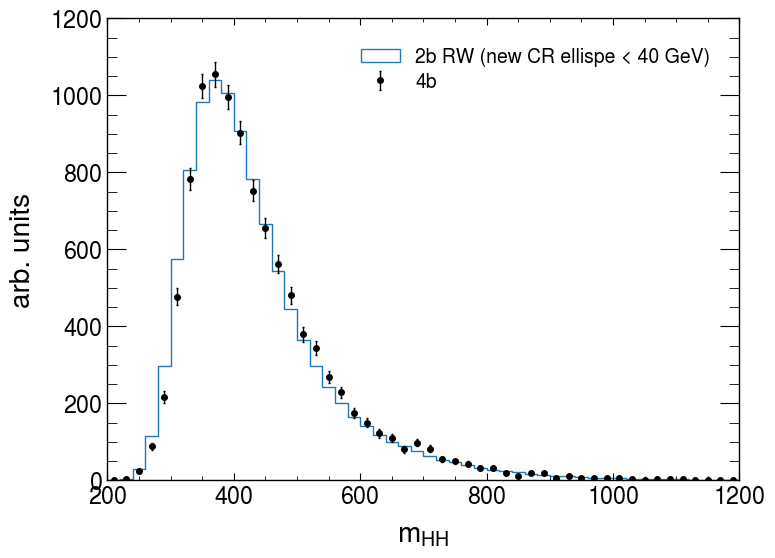

In [99]:
h4b, be = np.histogram(d_r.loc[(d_r['ntag']>=4) & (d_r['kr_new']==2), 'm_hh'], bins = be)
mask_2b = d_r['ntag']==2
mask_cr = d_r['kr_new']==2
plt.errorbar(x_be, h4b, yerr=np.sqrt(h4b), **errorbar_style, label="4b")
_ = plt.hist(
    d_r.loc[mask_2b & mask_cr, "m_hh"].values,
    bins=be,
    histtype="step",
    weights=d_r.loc[mask_2b & mask_cr, "NNnew"].values,
    label = '2b RW (new CR ellispe < 40 GeV)'
)
plt.legend()
plt.ylabel('arb. units')
plt.xlabel('$m_{HH}$')

In [100]:
from matplotlib import gridspec


/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:65: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Text(0.5, 1.0, 'Control Regions: Reweighting comparison between old CR and new CR\n using the elliptical Signal Region')

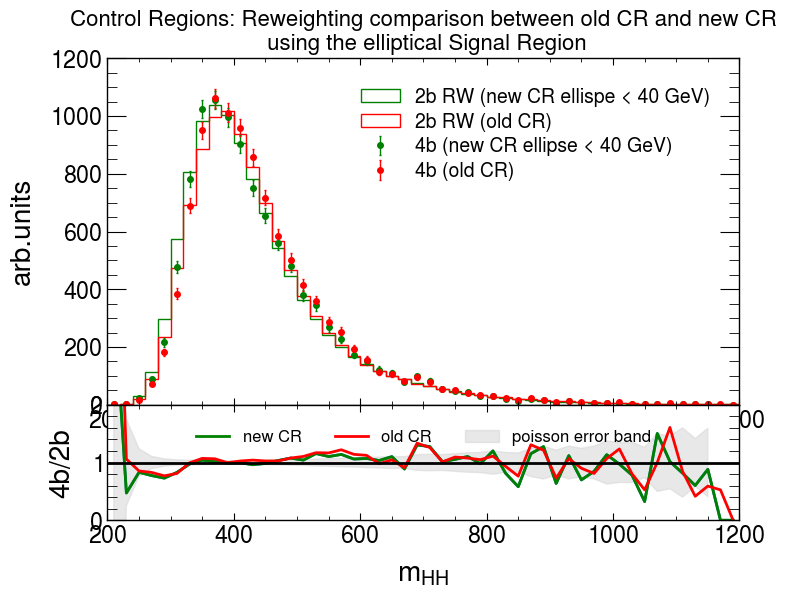

In [149]:
##PLOT SETUO
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
gs.update(wspace=0, hspace=0)
ax0 = plt.subplot(gs[0])

be = np.linspace(200, 1200, 51)
x_be = 0.5 * (be[:-1] + be[1:])
##CR NEW Histogram
h4b_new, be = np.histogram(
    d_r.loc[(d_r["ntag"] >= 4) & (d_r["kr_new"] == 2), "m_hh"], bins=be
)

ax0.errorbar(
    x_be,
    h4b_new,
    yerr=np.sqrt(h4b_new),
    **errorbar_style,
    mfc="green",
    mec="green",
    ecolor="green",
    label = '4b (new CR ellipse < 40 GeV)'
)

h2b_new, _, _ = ax0.hist(
    d_r.loc[(d_r["ntag"] == 2) & (d_r["kr_new"] == 2), "m_hh"].values,
    bins=be,
    histtype="step",
    weights=d_r.loc[(d_r["ntag"] == 2) & (d_r["kr_new"] == 2), "NNnew"].values,
    label="2b RW (new CR ellispe < 40 GeV)",
    color='green'
)


ax1 = plt.subplot(gs[1], sharex=ax0)
ax1.plot(x_be, h4b_new / h2b_new)

##CR old Histogram
h4b_old, be = np.histogram(
    d_r.loc[(d_r["ntag"] >= 4) & (d_r["kr_old"] == 2), "m_hh"], bins=be
)

ax0.errorbar(
    x_be,
    h4b_old,
    yerr=np.sqrt(h4b_old),
    **errorbar_style,
    mfc="red",
    mec="red",
    ecolor="red",
    label = '4b (old CR)'
)

h2b_old, _, _ = ax0.hist(
    d_r.loc[(d_r["ntag"] == 2) & (d_r["kr_old"] == 2), "m_hh"].values,
    bins=be,
    histtype="step",
    weights=d_r.loc[(d_r["ntag"] == 2) & (d_r["kr_old"] == 2), "NNold"].values,
    label="2b RW (old CR)",
    color='red'
)

err_R = (h4b_new / h2b_old) * np.sqrt(h4b_new) / h4b_new

ax1 = plt.subplot(gs[1], sharex=ax0)
ax1.plot(x_be, h4b_new / h2b_new, color= 'green', label = 'new CR')
ax1.plot(x_be, h4b_old / h2b_old, color= 'red', label = 'old CR')
ax1.fill_between(x_be, 1 - err_R, 1 + err_R, alpha=0.5, color='lightgrey',label ='poisson error band')


ax1.set_ylim(0., 2.0)
ax1.axhline(1, color="black")
ax1.set_ylabel("4b/2b")
ax0.set_ylabel("arb.units")
ax1.set_xlabel(r"$m_{HH}$")
ax0.legend()
ax1.legend(loc='upper center',ncol=3,fontsize=12)
ax0.set_title("Control Regions: Reweighting comparison between old CR and new CR\n using the elliptical Signal Region",fontsize=16)

/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
No handles with labels found to put in legend.


Text(0.5, 1.0, 'Signal Region: Reweighting comparison between old CR and new CR\n using the elliptical Signal Region')

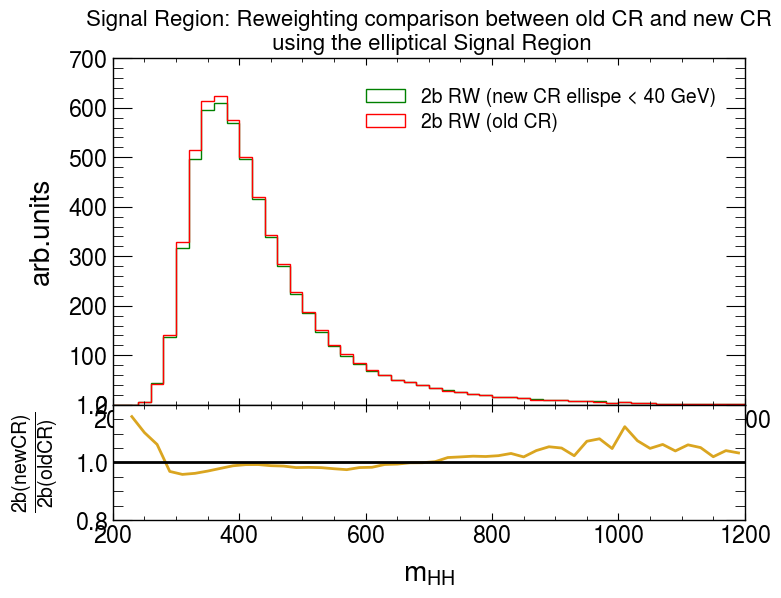

In [152]:
##PLOT SETUO
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
gs.update(wspace=0, hspace=0)
ax0 = plt.subplot(gs[0])

be = np.linspace(200, 1200, 51)
x_be = 0.5 * (be[:-1] + be[1:])
##CR NEW Histogram

h2b_new, _, _ = ax0.hist(
    d_r.loc[(d_r["ntag"] == 2) & (d_r["kr_new"] == 0), "m_hh"].values,
    bins=be,
    histtype="step",
    weights=d_r.loc[(d_r["ntag"] == 2) & (d_r["kr_new"] == 0), "NNnew"].values,
    label="2b RW (new CR ellispe < 40 GeV)",
    color="green",
)

##CR old Histogram

h2b_old, _, _ = ax0.hist(
    d_r.loc[(d_r["ntag"] == 2) & (d_r["kr_old"] == 0), "m_hh"].values,
    bins=be,
    histtype="step",
    weights=d_r.loc[(d_r["ntag"] == 2) & (d_r["kr_old"] == 0), "NNold"].values,
    label="2b RW (old CR)",
    color="red",
)


ax1 = plt.subplot(gs[1], sharex=ax0)
ax1.plot(x_be, h2b_new / h2b_old, color="goldenrod")


ax1.set_ylim(0.8, 1.2)
ax1.axhline(1, color="black")
ax1.set_ylabel(r"$\frac{2b (new CR)}{2b (old CR)}$")
ax0.set_ylabel("arb.units")
ax1.set_xlabel(r"$m_{HH}$")
ax0.legend()
ax1.legend(loc="upper center", ncol=3, fontsize=12)
ax0.set_title(
    "Signal Region: Reweighting comparison between old CR and new CR\n using the elliptical Signal Region",
    fontsize=16,
)

In [1]:
d_r

NameError: name 'd_r' is not defined

In [ ]:
h4b, be = np.histogram(d_r.loc[(d_r['ntag']>=4) & (d_r['kr_new']==2), 'm_hh'], bins = be)
mask_2b = d_r['ntag']==2
mask_cr = d_r['kr_new']==2
plt.errorbar(x_be, h4b, yerr=np.sqrt(h4b), **errorbar_style, label="4b")
_ = plt.hist(
    d_r.loc[mask_2b & mask_cr, "m_hh"].values,
    bins=be,
    histtype="step",
    weights=d_r.loc[mask_2b & mask_cr, "NNnew"].values,
    label = '2b RW (new CR ellispe < 40 GeV)'
)
plt.legend()
plt.ylabel('arb. units')
plt.xlabel('$m_{HH}$')

Text(0.5, 0, '$m_{HH}$')

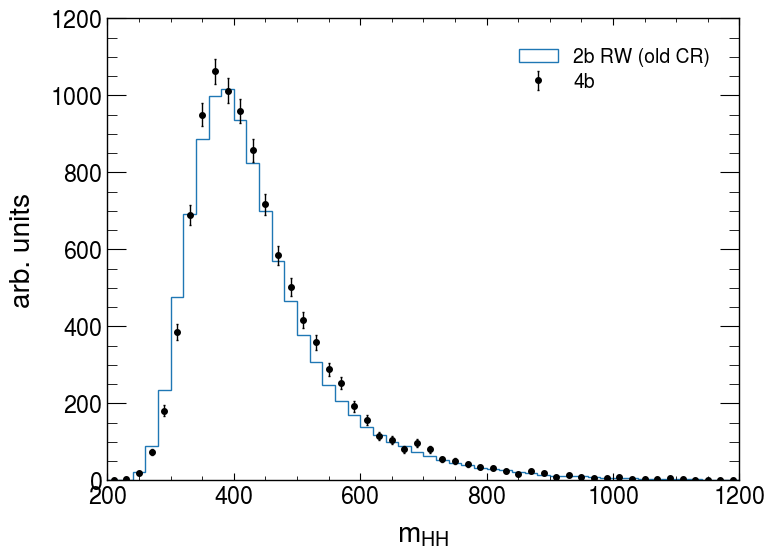

In [98]:
h4b, be = np.histogram(d_r.loc[(d_r['ntag']>=4) & (d_r['kr_old']==2), 'm_hh'], bins = be)
mask_2b = d_r['ntag']==2
mask_cr = d_r['kr_old']==2
plt.errorbar(x_be, h4b, yerr=np.sqrt(h4b), **errorbar_style, label="4b")
_ = plt.hist(
    d_r.loc[mask_2b & mask_cr, "m_hh"].values,
    bins=be,
    histtype="step",
    weights= d_r.loc[mask_2b & mask_cr, "NNold"].values,
    label = '2b RW (old CR)'
)
plt.legend()
plt.ylabel('arb. units')
plt.xlabel('$m_{HH}$')

Text(0.5, 0, '$m_{HH}$')

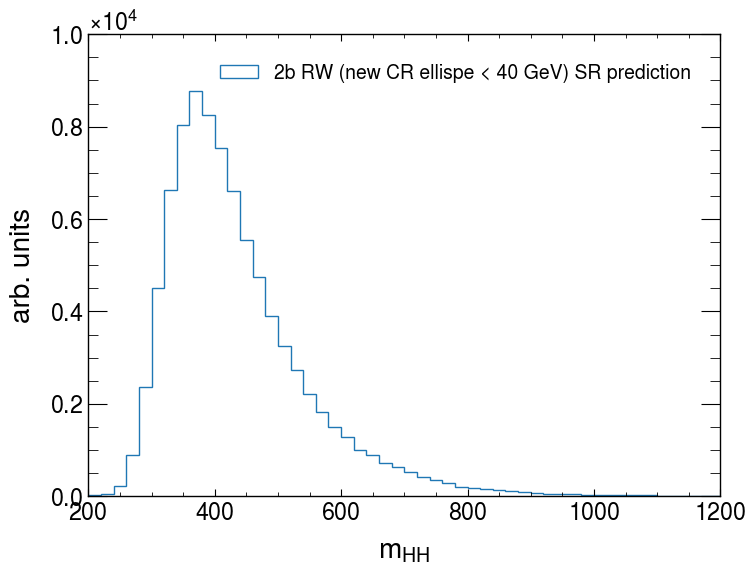

In [79]:
# plt.errorbar(x_be, h4b, yerr=np.sqrt(h4b), **errorbar_style, label="4b")
_ = plt.hist(
    d_r.loc[mask_2b & d_r['kinematic_region']==0, "m_hh"].values,
    bins=be,
    histtype="step",
    weights=norm * d_r.loc[mask_2b & d_r['kinematic_region']==0, "NN_weight_median_CR"].values,
    label = '2b RW (new CR ellispe < 40 GeV) SR prediction'
)
plt.legend()
plt.ylabel('arb. units')
plt.xlabel('$m_{HH}$')

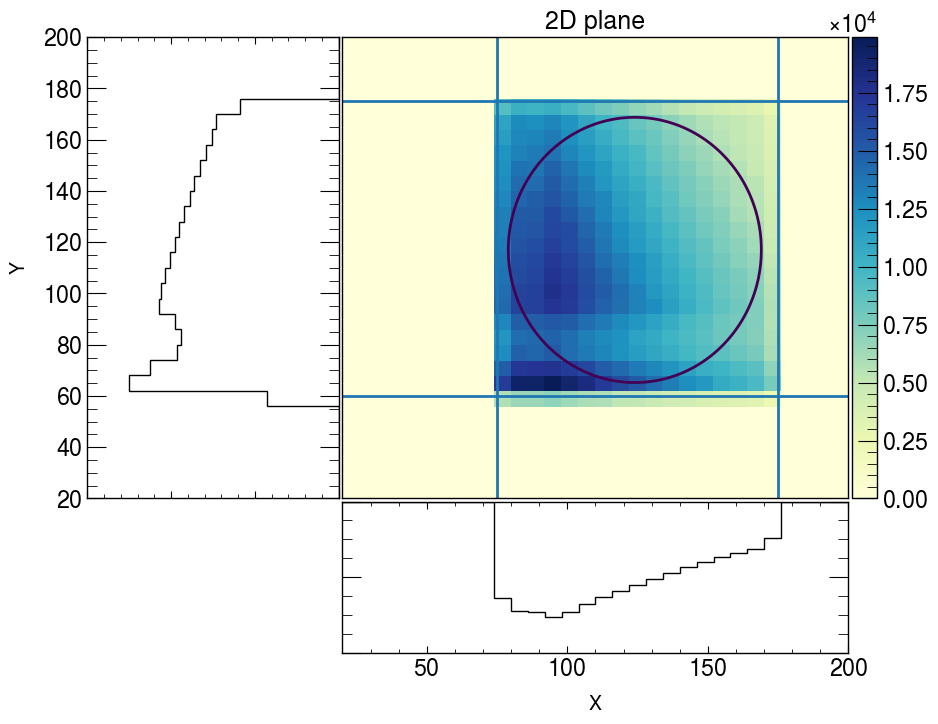

In [59]:
h = hist2d(d_r.m_h1, d_r.m_h2)
h['main_ax'].contour(X, Y, ellipse(X, Y, 1, 1.15), [45])
h['main_ax'].axvline(75)
h['main_ax'].axvline(175)
h['main_ax'].axhline(60)
h['main_ax'].axhline(175)


In [80]:
!ls -lh /mnt/storage/lborgna/NNT/MDR_VEC/data/

total 38G
-rw-r--r-- 1 lborgna users  627 May 13 01:19 copy.cpp
-rw-r--r-- 1 lborgna users 434M Apr  5 17:08 data_2B_SRshift_16.root
-rw-r--r-- 1 lborgna users 527M Apr  8 20:05 data_2B_SRshift_16_with_weights.root
-rw-r--r-- 1 lborgna users 404M Apr  5 17:17 data_2B_SRshift_17.root
-rw-r--r-- 1 lborgna users 478M Apr  8 20:06 data_2B_SRshift_17_with_weights.root
-rw-r--r-- 1 lborgna users 947M Apr  5 17:28 data_2B_SRshift_18.root
-rw-r--r-- 1 lborgna users 1.2G Apr  8 20:07 data_2B_SRshift_18_with_weights.root
-rw-r--r-- 1 lborgna users 4.0G Apr 16 15:04 data_2B_SRshift_fmp_16.root
-rw-r--r-- 1 lborgna users 3.8G Apr 20 17:58 data_2B_SRshift_fmp_17.root
-rw-r--r-- 1 lborgna users 8.6G Apr 20 18:08 data_2B_SRshift_fmp_18.root
-rw-r--r-- 1 lborgna users 421M Apr 14 11:06 data_CRVRSR_16.root
-rw-r--r-- 1 lborgna users 392M Apr 14 11:06 data_CRVRSR_17.root
-rw-r--r-- 1 lborgna users 915M Apr 14 11:08 data_CRVRSR_18.root
-rw-r--r-- 1 lborgna users  575 May 13 01:31 data_CRVRSR_2B_SRshift_1

In [34]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           125G         95G         26G        107M        3.3G         28G
Swap:           15G         15G        1.6M
